In [12]:
from util import *
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Bidirectional, LSTM, Reshape, RepeatVector, TimeDistributed
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import tensorflow_gan as tfgan
import tensorflow as tf
tf.compat.v1.enable_eager_execution() 

import matplotlib.pyplot as plt

import sys

import numpy as np
import pandas as pd

import os

from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data
Loading from preprocessed numpy array

# Creating GAN

In [29]:
class LSTMGAN():
    def __init__(self, step_i, step_o, f, data):
        self.data = data
        self.step_input = step_i
        self.step_output = step_o
        self.feature_len = f
        self.in_shape = (self.step_input, self.feature_len)
        self.out_shape = (self.step_output, self.feature_len)
        self.dis_shape = (self.step_input+self.step_output, self.feature_len)

        optimizer = Adam(0.0001, 0.4)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
        # Trains the generator to imitate input data
        self.generator.compile(loss='mean_squared_error',
            optimizer=optimizer)
        
        # The generator takes noise as input and generates song
        noise = Input(shape=self.in_shape)
        gen_output = self.generator(noise)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(merge_time_series(noise, gen_output))

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(noise, valid)
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        

    def build_generator(self):

        model = Sequential()
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=self.in_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(128)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(self.out_shape[0] * self.out_shape[1]))
        model.add(Reshape(self.out_shape))
        # model.summary()

        noise = Input(shape=self.in_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()
        
        model.add(Bidirectional(LSTM(128, activation = 'relu', return_sequences=True), input_shape=self.dis_shape))
        model.add(Dropout(0.4))
        model.add(TimeDistributed(Dense(128, activation = 'relu')))
        model.add(Dense(1, activation = 'linear'))
        #model.summary()

        img = Input(shape=self.dis_shape)
        validity = model(img)

        return Model(img, validity)
    
    
    def train(self, epochs, batch_size=128, save_interval=50):
    

        # Load the dataset
        (X_train_input, X_train_output) = split_time_series(self.step_input, self.step_output, self.data)

        # normalize

        # Adversarial ground truths
        valid = np.ones(batch_size)
        fake = np.zeros(batch_size)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------
            # Select a random half of songs
            idx = np.random.randint(0, X_train_input.shape[0], batch_size)
            real_input= X_train_input[idx]
            real_output= X_train_output[idx]
            
           
            
            (real_input, scalers) = batch_standardize(real_input)
            real_output = batch_scale(real_output, scalers)
            
            # Sample noise and generate a batch of new prices
            noise = np.random.normal(0, 1, (batch_size,self.step_input,self.feature_len))
            gen_output = self.generator.predict(noise, batch_size = batch_size)
            real_series = merge_time_series(real_input,real_output)
            fake_series = merge_time_series(real_input,gen_output)
            print("input:\n", scalers[0].inverse_transform( real_input[0]))
            print("fake_output:\n", scalers[0].inverse_transform( gen_output[0]))
            print("real_output:\n", scalers[0].inverse_transform( real_output[0]))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(real_series, valid)
            d_loss_fake = self.discriminator.train_on_batch(fake_series, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            # First training (wants generator to imitate real data)
            g_loss1 = self.generator.train_on_batch( np.array(real_input), np.array(real_output))
            
            # Second training (wants discriminator to mistake songs as real)
            g_loss2 = self.combined.train_on_batch(noise, valid)
            g_loss = 0.5 * np.add(g_loss1, g_loss2)



            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save model
            if epoch % save_interval == 0:
                self.generator.save("LSTM_generator.h5")

input shape, (461, 5, 4), output shape, (461, 5, 4)
input [[[4366.64 4411.01 4287.11 4356.45]
  [4356.32 4417.35 4222.62 4410.13]
  [4471.38 4494.52 4395.34 4397.94]
  [4547.35 4602.11 4477.95 4482.73]
  [4588.03 4611.55 4530.2  4532.76]]

 [[4356.32 4417.35 4222.62 4410.13]
  [4471.38 4494.52 4395.34 4397.94]
  [4547.35 4602.11 4477.95 4482.73]
  [4588.03 4611.55 4530.2  4532.76]
  [4632.24 4632.24 4568.7  4577.11]]

 [[4471.38 4494.52 4395.34 4397.94]
  [4547.35 4602.11 4477.95 4482.73]
  [4588.03 4611.55 4530.2  4532.76]
  [4632.24 4632.24 4568.7  4577.11]
  [4637.99 4665.13 4614.75 4662.85]]

 ...

 [[2498.08 2522.75 2447.49 2470.5 ]
  [2614.69 2641.39 2571.15 2584.59]
  [2558.98 2631.8  2545.28 2626.65]
  [2555.87 2615.91 2520.02 2541.47]
  [2501.29 2637.01 2500.72 2630.07]]

 [[2614.69 2641.39 2571.15 2584.59]
  [2558.98 2631.8  2545.28 2626.65]
  [2555.87 2615.91 2520.02 2541.47]
  [2501.29 2637.01 2500.72 2630.07]
  [2457.77 2571.42 2407.53 2475.56]]

 [[2558.98 2631.8  2545.28

# Model Summary
I couldn't train the model on this online notebook so I trained it locally for 1000 epochs and uploaded the h5 file.

In [30]:
data = load_data("./data_stock/SP500_average.csv")
step_i = 5
step_o = 5
f = 4
lstmgan = LSTMGAN(step_i, step_0, f , data)
lstmgan.train(epochs=1000, batch_size=50, save_interval=100)

input:
 [[4691.   4695.26 4665.98 4667.45]
 [4690.86 4705.06 4674.52 4701.21]
 [4631.97 4694.04 4631.97 4686.75]
 [4548.37 4612.6  4540.51 4591.67]
 [4589.49 4608.03 4495.12 4538.43]]
fake_output:
 [[4630.8774 4663.6006 4603.398  4637.302 ]
 [4630.0776 4663.9146 4602.5054 4636.432 ]
 [4630.1807 4663.015  4601.974  4636.8477]
 [4629.808  4662.988  4602.9707 4637.827 ]
 [4628.63   4662.843  4601.6123 4634.543 ]]
real_output:
 [[4504.73 4595.46 4504.73 4577.1 ]
 [4602.82 4652.94 4510.27 4513.04]
 [4640.25 4646.02 4560.   4567.  ]
 [4628.75 4672.95 4625.26 4655.27]
 [4664.63 4664.63 4585.43 4594.62]]
0 [D loss: 4.792281, acc.: 50.50%] [G loss: 8.221984]
input:
 [[3815.05 3826.69 3783.6  3824.68]
 [3764.71 3811.55 3764.71 3803.79]
 [3712.2  3783.04 3705.34 3748.14]
 [3698.02 3737.83 3695.07 3726.86]
 [3764.61 3769.99 3662.71 3700.65]]
fake_output:
 [[3751.3518 3786.9536 3722.355  3761.3025]
 [3751.1106 3785.8777 3720.8894 3760.842 ]
 [3751.142  3785.8535 3723.0605 3759.9365]
 [3750.5322 378

13 [D loss: 0.882690, acc.: 55.00%] [G loss: 8.176109]
input:
 [[4366.64 4411.01 4287.11 4356.45]
 [4356.32 4417.35 4222.62 4410.13]
 [4471.38 4494.52 4395.34 4397.94]
 [4547.35 4602.11 4477.95 4482.73]
 [4588.03 4611.55 4530.2  4532.76]]
fake_output:
 [[4467.9614 4505.871  4381.178  4434.025 ]
 [4465.7383 4505.61   4380.633  4434.039 ]
 [4465.7104 4504.0884 4379.308  4433.231 ]
 [4467.3965 4504.5845 4379.6733 4434.5854]
 [4461.9766 4505.477  4377.99   4432.6543]]
real_output:
 [[4632.24 4632.24 4568.7  4577.11]
 [4637.99 4665.13 4614.75 4662.85]
 [4733.56 4744.13 4650.29 4659.03]
 [4728.59 4748.83 4706.71 4726.35]
 [4669.14 4714.13 4638.27 4713.07]]
14 [D loss: 0.803664, acc.: 59.20%] [G loss: 12.329818]
input:
 [[4385.44 4415.88 4360.59 4361.19]
 [4406.51 4412.02 4386.22 4391.34]
 [4383.73 4429.97 4383.73 4399.76]
 [4319.57 4365.57 4290.49 4363.55]
 [4309.87 4369.23 4309.87 4345.72]]
fake_output:
 [[4363.1367 4398.6616 4344.333  4372.1074]
 [4362.829  4398.06   4344.1924 4371.9355]
 

26 [D loss: 0.747123, acc.: 55.30%] [G loss: 4.489429]
input:
 [[3368.66 3378.51 3361.64 3372.85]
 [3372.95 3387.24 3363.35 3373.43]
 [3355.46 3387.89 3355.46 3380.35]
 [3370.34 3381.01 3326.44 3333.69]
 [3356.04 3363.29 3335.44 3360.47]]
fake_output:
 [[3365.4258 3377.7715 3347.5305 3360.8967]
 [3364.0227 3378.9734 3346.9922 3361.2095]
 [3364.7095 3377.9714 3346.5146 3361.4082]
 [3364.4734 3378.1294 3346.303  3362.8613]
 [3363.253  3377.7673 3345.1174 3359.9756]]
real_output:
 [[3340.05 3352.54 3328.72 3351.28]
 [3323.17 3351.03 3318.14 3349.16]
 [3317.37 3330.77 3317.37 3327.77]
 [3289.92 3306.84 3286.37 3306.51]
 [3288.26 3302.73 3284.53 3294.61]]
27 [D loss: 0.673980, acc.: 60.50%] [G loss: 6.160291]
input:
 [[3336.25 3389.49 3336.25 3369.16]
 [3296.2  3330.14 3279.74 3310.24]
 [3293.59 3304.93 3233.94 3269.96]
 [3277.17 3341.05 3259.82 3310.11]
 [3342.48 3342.48 3268.89 3271.03]]
fake_output:
 [[3311.6187 3335.9548 3273.583  3298.8408]
 [3306.9075 3338.7256 3271.9226 3298.4243]
 [

40 [D loss: 0.600789, acc.: 65.90%] [G loss: 6.785934]
input:
 [[3407.73 3419.48 3389.25 3401.2 ]
 [3363.56 3402.93 3363.56 3383.54]
 [3352.7  3368.95 3310.47 3340.97]
 [3412.56 3425.55 3329.25 3339.19]
 [3369.82 3424.77 3366.84 3398.96]]
fake_output:
 [[3384.364  3402.9387 3349.406  3365.0662]
 [3377.6357 3405.697  3346.9429 3364.7998]
 [3380.267  3402.033  3345.3687 3366.5774]
 [3379.7932 3402.0203 3345.65   3366.8218]
 [3373.164  3401.716  3342.5059 3363.8293]]
real_output:
 [[3371.88 3379.97 3329.27 3331.84]
 [3453.6  3479.15 3349.63 3426.96]
 [3564.74 3564.85 3427.41 3455.06]
 [3543.76 3588.11 3535.23 3580.84]
 [3507.44 3528.03 3494.6  3526.65]]
41 [D loss: 0.597724, acc.: 64.80%] [G loss: 5.252097]
input:
 [[3094.42 3120.92 3079.39 3117.86]
 [3140.29 3155.53 3083.11 3097.74]
 [3101.64 3120.   3093.51 3115.34]
 [3136.13 3141.16 3108.03 3113.49]
 [3131.   3153.45 3076.06 3124.74]]
fake_output:
 [[3122.1062 3131.4756 3085.738  3110.1   ]
 [3115.2866 3134.054  3084.7424 3109.4988]
 [

53 [D loss: 0.636457, acc.: 63.00%] [G loss: 5.070395]
input:
 [[3114.4  3115.01 3032.13 3050.33]
 [3138.7  3154.9  3127.12 3131.29]
 [3094.42 3120.92 3079.39 3117.86]
 [3140.29 3155.53 3083.11 3097.74]
 [3101.64 3120.   3093.51 3115.34]]
fake_output:
 [[3119.8555 3126.896  3074.156  3089.3513]
 [3111.656  3126.4417 3070.407  3087.2266]
 [3113.0505 3122.5706 3066.1873 3089.2224]
 [3113.7756 3121.7192 3067.4346 3087.6875]
 [3105.7686 3121.817  3061.1807 3084.6567]]
real_output:
 [[3136.13 3141.16 3108.03 3113.49]
 [3131.   3153.45 3076.06 3124.74]
 [2993.76 3079.76 2965.66 3066.59]
 [3071.04 3088.42 2984.47 3041.31]
 [3123.53 3123.53 2999.49 3002.1 ]]
54 [D loss: 0.525704, acc.: 73.60%] [G loss: 7.741115]
input:
 [[3793.58 3851.69 3730.19 3841.94]
 [3818.53 3843.67 3723.34 3768.47]
 [3863.99 3874.47 3818.86 3819.72]
 [3903.64 3906.41 3868.57 3870.29]
 [3842.51 3914.5  3842.51 3901.82]]
fake_output:
 [[3843.9138 3863.4387 3776.5093 3813.5923]
 [3826.468  3864.5857 3767.728  3810.0234]
 [

input:
 [[4366.64 4411.01 4287.11 4356.45]
 [4356.32 4417.35 4222.62 4410.13]
 [4471.38 4494.52 4395.34 4397.94]
 [4547.35 4602.11 4477.95 4482.73]
 [4588.03 4611.55 4530.2  4532.76]]
fake_output:
 [[4444.044  4439.6753 4319.9585 4382.751 ]
 [4399.3604 4446.424  4302.992  4375.572 ]
 [4414.848  4422.012  4269.8325 4379.6436]
 [4400.041  4414.028  4267.446  4370.5654]
 [4363.7124 4414.3066 4247.361  4361.3076]]
real_output:
 [[4632.24 4632.24 4568.7  4577.11]
 [4637.99 4665.13 4614.75 4662.85]
 [4733.56 4744.13 4650.29 4659.03]
 [4728.59 4748.83 4706.71 4726.35]
 [4669.14 4714.13 4638.27 4713.07]]
67 [D loss: 0.494327, acc.: 77.40%] [G loss: 5.125984]
input:
 [[3370.34 3381.01 3326.44 3333.69]
 [3356.04 3363.29 3335.44 3360.47]
 [3340.05 3352.54 3328.72 3351.28]
 [3323.17 3351.03 3318.14 3349.16]
 [3317.37 3330.77 3317.37 3327.77]]
fake_output:
 [[3336.571  3342.221  3321.0583 3333.717 ]
 [3326.7798 3342.7698 3319.7612 3332.1956]
 [3329.0454 3338.4846 3318.2937 3332.3503]
 [3327.3262 33

79 [D loss: 0.554186, acc.: 71.30%] [G loss: 4.458565]
input:
 [[4490.45 4501.71 4485.66 4496.19]
 [4484.4  4492.81 4482.28 4486.23]
 [4450.29 4489.88 4450.29 4479.53]
 [4410.56 4444.35 4406.8  4441.67]
 [4382.44 4418.61 4367.73 4405.8 ]]
fake_output:
 [[4401.7637 4415.1255 4371.2363 4401.5386]
 [4369.207  4407.557  4350.1807 4391.4644]
 [4367.979  4394.406  4326.8154 4382.665 ]
 [4358.1147 4387.325  4317.4995 4378.2935]
 [4332.348  4381.869  4303.8755 4366.5684]]
real_output:
 [[4440.94 4454.32 4397.59 4400.27]
 [4462.12 4462.12 4417.83 4448.08]
 [4461.65 4480.26 4437.66 4479.71]
 [4464.84 4468.37 4460.82 4468.  ]
 [4446.08 4461.77 4435.96 4460.83]]
80 [D loss: 0.584905, acc.: 68.00%] [G loss: 5.137467]
input:
 [[3342.48 3342.48 3268.89 3271.03]
 [3403.15 3409.51 3388.71 3390.68]
 [3441.42 3441.42 3364.86 3400.97]
 [3464.9  3466.46 3440.45 3465.39]
 [3438.5  3460.53 3415.34 3453.49]]
fake_output:
 [[3397.48   3375.7407 3317.9521 3310.407 ]
 [3368.0024 3367.3445 3299.1782 3295.6062]
 [

92 [D loss: 0.558505, acc.: 69.10%] [G loss: 4.153910]
input:
 [[3050.2  3111.51 3047.83 3100.29]
 [3018.59 3053.89 2999.74 3053.24]
 [3073.2  3073.73 3004.63 3009.05]
 [3046.6  3086.25 3024.01 3083.76]
 [3114.4  3115.01 3032.13 3050.33]]
fake_output:
 [[3031.2502 3052.2407 2994.6926 3003.11  ]
 [2995.36   3040.362  2981.626  2990.498 ]
 [2990.4397 3031.9595 2976.118  2979.3997]
 [2986.6443 3025.3306 2970.349  2981.9536]
 [2972.2932 3021.2756 2965.5596 2965.4128]]
real_output:
 [[3138.7  3154.9  3127.12 3131.29]
 [3094.42 3120.92 3079.39 3117.86]
 [3140.29 3155.53 3083.11 3097.74]
 [3101.64 3120.   3093.51 3115.34]
 [3136.13 3141.16 3108.03 3113.49]]
93 [D loss: 0.583193, acc.: 65.80%] [G loss: 5.206531]
input:
 [[3418.09 3432.09 3413.13 3431.28]
 [3386.01 3399.96 3379.31 3397.16]
 [3360.48 3390.8  3354.69 3385.51]
 [3392.51 3399.54 3369.66 3374.85]
 [3387.04 3395.06 3370.15 3389.78]]
fake_output:
 [[3376.5598 3387.308  3358.996  3373.24  ]
 [3364.878  3383.9585 3350.0417 3367.41  ]
 [

105 [D loss: 0.529932, acc.: 72.60%] [G loss: 4.317287]
input:
 [[4788.64 4804.06 4778.08 4793.06]
 [4795.49 4807.02 4780.04 4786.35]
 [4733.99 4791.49 4733.99 4791.19]
 [4703.96 4740.74 4703.96 4725.79]
 [4650.36 4697.67 4645.53 4696.56]]
fake_output:
 [[4677.548  4708.3247 4670.4175 4705.2583]
 [4651.1055 4703.337  4649.059  4690.2563]
 [4649.575  4688.3105 4631.2534 4682.273 ]
 [4633.304  4681.8394 4621.1733 4674.8696]
 [4615.177  4678.3164 4613.8857 4669.7397]]
real_output:
 [[4594.96 4651.14 4583.16 4649.23]
 [4587.9  4587.9  4531.1  4568.02]
 [4652.5  4666.7  4600.22 4620.64]
 [4719.13 4731.99 4651.89 4668.67]
 [4636.46 4712.6  4611.22 4709.85]]
106 [D loss: 0.534364, acc.: 71.70%] [G loss: 4.709175]
input:
 [[4368.31 4374.89 4342.09 4350.65]
 [4385.44 4415.88 4360.59 4361.19]
 [4406.51 4412.02 4386.22 4391.34]
 [4383.73 4429.97 4383.73 4399.76]
 [4319.57 4365.57 4290.49 4363.55]]
fake_output:
 [[4359.5654 4378.383  4325.084  4355.0947]
 [4341.8096 4372.7695 4311.347  4349.975 ]


118 [D loss: 0.485316, acc.: 75.60%] [G loss: 6.202235]
input:
 [[3693.42 3711.24 3689.28 3690.01]
 [3698.08 3698.26 3676.16 3687.26]
 [3684.28 3702.9  3636.48 3694.92]
 [3722.39 3726.7  3685.84 3709.41]
 [3713.65 3725.12 3710.87 3722.48]]
fake_output:
 [[3699.9104 3704.496  3664.2014 3687.5557]
 [3687.621  3702.0234 3652.6355 3685.5193]
 [3686.0305 3697.8296 3647.2166 3683.802 ]
 [3684.1274 3695.4211 3643.5242 3684.4119]
 [3681.2534 3693.4944 3638.3179 3678.3035]]
real_output:
 [[3696.25 3711.27 3688.57 3701.17]
 [3666.41 3695.29 3659.62 3694.62]
 [3675.27 3697.61 3645.84 3647.49]
 [3656.08 3665.91 3633.4  3663.46]
 [3659.13 3678.49 3645.18 3668.1 ]]
119 [D loss: 0.547391, acc.: 71.70%] [G loss: 4.871135]
input:
 [[3205.08 3235.32 3149.43 3155.22]
 [3152.47 3186.82 3136.22 3185.04]
 [3176.17 3179.78 3115.7  3152.05]
 [3153.07 3171.8  3136.53 3169.94]
 [3166.44 3184.15 3142.93 3145.32]]
fake_output:
 [[3158.6953 3170.0854 3127.7454 3147.4353]
 [3149.4233 3167.8342 3124.0957 3143.5393]


131 [D loss: 0.534487, acc.: 71.20%] [G loss: 5.754625]
input:
 [[3793.58 3851.69 3730.19 3841.94]
 [3818.53 3843.67 3723.34 3768.47]
 [3863.99 3874.47 3818.86 3819.72]
 [3903.64 3906.41 3868.57 3870.29]
 [3842.51 3914.5  3842.51 3901.82]]
fake_output:
 [[3835.689  3864.446  3774.8044 3815.21  ]
 [3819.5208 3860.076  3757.3325 3804.299 ]
 [3815.7034 3853.2969 3747.056  3802.352 ]
 [3814.2097 3848.22   3739.9363 3799.1714]
 [3802.6218 3846.6675 3735.0107 3791.788 ]]
real_output:
 [[3839.66 3861.08 3789.54 3811.15]
 [3915.8  3925.02 3814.04 3829.34]
 [3873.71 3928.65 3859.6  3925.43]
 [3857.07 3895.98 3805.59 3881.37]
 [3885.55 3902.92 3874.71 3876.5 ]]
132 [D loss: 0.466047, acc.: 78.50%] [G loss: 4.162562]
input:
 [[4372.41 4386.68 4364.03 4384.63]
 [4329.38 4371.6  4329.38 4369.55]
 [4321.07 4330.88 4289.37 4320.82]
 [4351.01 4361.88 4329.79 4358.13]
 [4356.46 4356.46 4314.37 4343.54]]
fake_output:
 [[4331.9424 4340.52   4302.8345 4329.322 ]
 [4319.6855 4336.582  4290.933  4321.634 ]


input:
 [[3873.71 3928.65 3859.6  3925.43]
 [3857.07 3895.98 3805.59 3881.37]
 [3885.55 3902.92 3874.71 3876.5 ]
 [3921.16 3930.41 3903.07 3906.71]
 [3915.86 3921.98 3885.03 3913.97]]
fake_output:
 [[3842.9333 3883.211  3797.7607 3855.4714]
 [3824.7378 3876.323  3770.2869 3845.9336]
 [3814.7937 3870.572  3755.684  3837.8071]
 [3811.7837 3867.2632 3744.3735 3834.0579]
 [3800.2676 3863.4146 3738.6958 3829.551 ]]
real_output:
 [[3918.5  3933.61 3900.43 3931.33]
 [3939.61 3950.43 3923.85 3932.59]
 [3911.65 3937.23 3905.78 3934.83]
 [3916.4  3925.99 3890.39 3916.38]
 [3920.78 3931.5  3884.94 3909.88]]
145 [D loss: 0.468140, acc.: 78.80%] [G loss: 4.675507]
input:
 [[4474.1  4513.33 4474.1  4509.37]
 [4493.75 4495.9  4468.99 4470.  ]
 [4490.45 4501.71 4485.66 4496.19]
 [4484.4  4492.81 4482.28 4486.23]
 [4450.29 4489.88 4450.29 4479.53]]
fake_output:
 [[4471.9907 4491.3604 4464.2524 4474.3784]
 [4460.6104 4489.9487 4458.389  4471.359 ]
 [4458.1206 4487.0063 4455.322  4469.9766]
 [4456.5923 4

157 [D loss: 0.468957, acc.: 78.40%] [G loss: 5.015221]
input:
 [[4690.86 4705.06 4674.52 4701.21]
 [4631.97 4694.04 4631.97 4686.75]
 [4548.37 4612.6  4540.51 4591.67]
 [4589.49 4608.03 4495.12 4538.43]
 [4504.73 4595.46 4504.73 4577.1 ]]
fake_output:
 [[4596.122  4631.6978 4564.5703 4596.2603]
 [4560.931  4627.2827 4541.3706 4588.6206]
 [4556.8457 4612.443  4528.8076 4584.962 ]
 [4551.597  4606.798  4524.334  4581.4277]
 [4537.5547 4603.425  4515.9214 4567.8296]]
real_output:
 [[4602.82 4652.94 4510.27 4513.04]
 [4640.25 4646.02 4560.   4567.  ]
 [4628.75 4672.95 4625.26 4655.27]
 [4664.63 4664.63 4585.43 4594.62]
 [4675.78 4702.87 4659.89 4701.46]]
158 [D loss: 0.504268, acc.: 76.20%] [G loss: 3.800122]
input:
 [[4169.92 4171.92 4142.69 4163.29]
 [4129.58 4183.13 4129.58 4173.85]
 [4074.99 4131.58 4074.99 4112.5 ]
 [4130.55 4134.73 4056.88 4063.04]
 [4150.34 4162.04 4111.53 4152.1 ]]
fake_output:
 [[4121.8813 4142.7207 4090.217  4101.1157]
 [4098.779  4139.2056 4073.9944 4091.2786]


input:
 [[3675.27 3697.61 3645.84 3647.49]
 [3656.08 3665.91 3633.4  3663.46]
 [3659.13 3678.49 3645.18 3668.1 ]
 [3705.98 3712.39 3660.54 3672.82]
 [3683.05 3708.45 3678.83 3702.25]]
fake_output:
 [[3644.8984 3653.814  3626.7563 3634.4333]
 [3633.1658 3649.5962 3615.2607 3625.877 ]
 [3628.1858 3639.592  3607.225  3617.633 ]
 [3621.5344 3635.8403 3599.8757 3613.215 ]
 [3611.082  3628.1125 3595.6194 3607.0662]]
real_output:
 [[3694.73 3697.41 3678.88 3691.96]
 [3670.94 3699.2  3670.94 3699.12]
 [3668.28 3682.73 3657.17 3666.72]
 [3653.78 3670.96 3644.84 3669.01]
 [3645.87 3678.45 3645.87 3662.45]]
171 [D loss: 0.504455, acc.: 74.90%] [G loss: 5.024741]
input:
 [[4309.87 4369.23 4309.87 4345.72]
 [4348.84 4355.51 4278.94 4300.46]
 [4317.16 4375.19 4288.52 4357.04]
 [4370.67 4382.55 4306.24 4307.54]
 [4362.41 4385.57 4355.08 4359.46]]
fake_output:
 [[4297.9634 4348.87   4258.5166 4276.9375]
 [4277.527  4344.3716 4235.61   4265.3447]
 [4267.2803 4338.8013 4222.3125 4251.335 ]
 [4262.27   4

183 [D loss: 0.558219, acc.: 66.80%] [G loss: 7.970438]
input:
 [[4469.74 4471.52 4427.76 4432.99]
 [4477.09 4485.87 4443.8  4473.75]
 [4447.49 4486.87 4438.37 4480.7 ]
 [4479.33 4485.68 4435.46 4443.05]
 [4474.81 4492.99 4445.7  4468.73]]
fake_output:
 [[4465.881  4477.3164 4433.644  4435.017 ]
 [4449.528  4474.665  4427.697  4432.4023]
 [4446.989  4470.9224 4426.3457 4426.895 ]
 [4445.874  4468.5757 4423.5474 4431.5366]
 [4443.3975 4466.173  4421.704  4414.9985]]
real_output:
 [[4506.92 4520.47 4457.66 4458.58]
 [4513.02 4529.9  4492.07 4493.28]
 [4518.09 4521.79 4493.95 4514.07]
 [4535.38 4535.38 4513.   4520.03]
 [4532.42 4541.45 4521.3  4535.43]]
184 [D loss: 0.504663, acc.: 72.40%] [G loss: 4.548676]
input:
 [[3953.5  3969.62 3910.86 3915.46]
 [3949.57 3983.87 3935.74 3974.12]
 [3973.59 3981.04 3953.44 3962.71]
 [3942.96 3970.08 3923.54 3968.94]
 [3924.52 3944.99 3915.21 3943.34]]
fake_output:
 [[3921.1975 3942.4724 3904.0083 3915.5212]
 [3915.4473 3940.8584 3895.4417 3905.5903]


196 [D loss: 0.531689, acc.: 73.20%] [G loss: 3.207638]
input:
 [[4469.74 4471.52 4427.76 4432.99]
 [4477.09 4485.87 4443.8  4473.75]
 [4447.49 4486.87 4438.37 4480.7 ]
 [4479.33 4485.68 4435.46 4443.05]
 [4474.81 4492.99 4445.7  4468.73]]
fake_output:
 [[4456.323  4473.2856 4431.365  4429.2363]
 [4446.152  4471.571  4426.096  4423.2085]
 [4444.074  4467.086  4423.5366 4417.328 ]
 [4442.5796 4465.406  4420.7793 4413.1445]
 [4437.6357 4464.053  4419.989  4406.8223]]
real_output:
 [[4506.92 4520.47 4457.66 4458.58]
 [4513.02 4529.9  4492.07 4493.28]
 [4518.09 4521.79 4493.95 4514.07]
 [4535.38 4535.38 4513.   4520.03]
 [4532.42 4541.45 4521.3  4535.43]]
197 [D loss: 0.487296, acc.: 72.40%] [G loss: 9.632741]
input:
 [[3507.44 3528.03 3494.6  3526.65]
 [3509.73 3514.77 3493.25 3500.31]
 [3494.69 3509.23 3484.32 3508.01]
 [3485.14 3501.38 3468.35 3484.55]
 [3449.97 3481.07 3444.15 3478.73]]
fake_output:
 [[3462.299  3487.6377 3461.5752 3485.2817]
 [3468.7593 3490.5972 3461.4172 3478.2256]


input:
 [[4402.95 4415.47 4387.01 4400.64]
 [4416.38 4416.38 4372.51 4401.46]
 [4409.58 4422.73 4405.45 4422.3 ]
 [4381.2  4415.18 4381.2  4411.79]
 [4361.27 4369.87 4350.06 4367.48]]
fake_output:
 [[4385.0103 4398.8916 4376.934  4396.3164]
 [4387.842  4400.959  4375.523  4391.808 ]
 [4385.523  4396.193  4371.784  4390.838 ]
 [4386.9233 4396.026  4367.454  4386.0537]
 [4377.403  4395.2544 4369.0273 4388.9253]]
real_output:
 [[4331.13 4359.7  4331.13 4358.69]
 [4265.11 4336.84 4262.05 4323.06]
 [4296.4  4296.4  4233.13 4258.49]
 [4367.43 4375.09 4322.53 4327.16]
 [4369.02 4369.02 4340.7  4360.03]]
210 [D loss: 0.509462, acc.: 74.00%] [G loss: 5.660872]
input:
 [[4580.22 4584.57 4551.66 4551.68]
 [4578.69 4598.53 4569.17 4574.79]
 [4553.69 4572.62 4537.36 4566.48]
 [4546.12 4559.67 4524.   4544.9 ]
 [4532.24 4551.44 4526.89 4549.78]]
fake_output:
 [[4539.6694 4553.8345 4529.1484 4545.4253]
 [4535.2573 4552.8164 4523.444  4542.367 ]
 [4532.8794 4546.7197 4518.0215 4540.1797]
 [4531.08   4

222 [D loss: 0.506440, acc.: 74.00%] [G loss: 3.972339]
input:
 [[3600.16 3628.51 3600.16 3626.91]
 [3552.57 3593.66 3552.57 3585.15]
 [3562.67 3569.02 3518.58 3537.01]
 [3563.22 3581.16 3557.   3572.66]
 [3543.26 3557.22 3511.91 3545.53]]
fake_output:
 [[3554.578  3565.81   3535.8062 3543.9353]
 [3542.1267 3562.7075 3515.29   3536.9019]
 [3535.7021 3549.3994 3503.9011 3530.4783]
 [3535.0957 3543.67   3491.6855 3524.7456]
 [3527.589  3539.2249 3491.9114 3516.809 ]]
real_output:
 [[3583.04 3645.99 3547.48 3550.5 ]
 [3508.34 3521.58 3484.34 3509.44]
 [3485.74 3529.05 3485.74 3510.45]
 [3406.46 3486.25 3405.17 3443.44]
 [3336.25 3389.49 3336.25 3369.16]]
223 [D loss: 0.492781, acc.: 75.80%] [G loss: 3.537265]
input:
 [[3356.04 3363.29 3335.44 3360.47]
 [3340.05 3352.54 3328.72 3351.28]
 [3323.17 3351.03 3318.14 3349.16]
 [3317.37 3330.77 3317.37 3327.77]
 [3289.92 3306.84 3286.37 3306.51]]
fake_output:
 [[3317.6042 3313.0774 3306.6333 3302.7932]
 [3273.765  3308.5547 3281.8083 3303.53  ]


input:
 [[4707.25 4708.53 4670.87 4685.25]
 [4701.48 4714.92 4694.39 4701.7 ]
 [4699.26 4718.5  4681.32 4697.53]
 [4662.93 4683.   4662.59 4680.06]
 [4630.65 4663.46 4621.19 4660.57]]
fake_output:
 [[4684.435  4689.328  4667.099  4674.1724]
 [4650.6577 4688.1157 4646.831  4674.765 ]
 [4645.8955 4673.331  4642.305  4671.6377]
 [4641.9526 4669.874  4631.7783 4673.886 ]
 [4636.2153 4664.6895 4631.0815 4663.7266]]
real_output:
 [[4613.34 4635.15 4613.34 4630.65]
 [4610.62 4620.34 4595.06 4613.67]
 [4572.87 4608.08 4567.59 4605.38]
 [4562.84 4597.55 4562.84 4596.42]
 [4580.22 4584.57 4551.66 4551.68]]
236 [D loss: 0.510985, acc.: 74.40%] [G loss: 3.823272]
input:
 [[3025.17 3049.17 2998.61 3044.31]
 [3046.61 3068.67 3023.4  3029.73]
 [3015.65 3036.25 2969.75 3036.13]
 [3004.08 3021.72 2988.17 2991.77]
 [2948.05 2956.76 2933.59 2955.45]]
fake_output:
 [[2966.645  2974.6648 2958.1792 2968.736 ]
 [2955.6614 2975.4985 2941.401  2959.5703]
 [2950.9243 2954.9631 2927.4307 2952.196 ]
 [2949.6    2

249 [D loss: 0.439080, acc.: 80.60%] [G loss: 5.931008]
input:
 [[2918.46 2954.86 2912.16 2939.51]
 [2909.96 2921.15 2860.71 2863.39]
 [2854.65 2887.72 2852.89 2878.48]
 [2812.64 2842.71 2791.76 2836.74]
 [2810.42 2844.9  2794.26 2797.8 ]]
fake_output:
 [[2856.9358 2885.974  2848.0933 2864.8145]
 [2857.6633 2889.973  2843.905  2858.7183]
 [2854.2498 2882.1213 2838.4697 2856.8462]
 [2856.3076 2883.8364 2830.2847 2851.416 ]
 [2846.5298 2879.866  2833.3633 2852.7495]]
real_output:
 [[2787.89 2815.1  2775.95 2799.31]
 [2784.81 2785.54 2727.1  2736.56]
 [2845.62 2868.98 2820.43 2823.16]
 [2842.43 2879.22 2830.88 2874.56]
 [2799.34 2806.51 2764.32 2799.55]]
250 [D loss: 0.490534, acc.: 74.80%] [G loss: 4.777887]
input:
 [[4296.4  4296.4  4233.13 4258.49]
 [4367.43 4375.09 4322.53 4327.16]
 [4369.02 4369.02 4340.7  4360.03]
 [4380.11 4393.68 4362.36 4374.3 ]
 [4381.07 4392.37 4366.92 4369.21]]
fake_output:
 [[4297.5166 4296.7964 4260.0386 4258.822 ]
 [4292.4106 4296.3887 4228.103  4242.1997]


input:
 [[3924.52 3944.99 3915.21 3943.34]
 [3915.54 3960.27 3915.54 3939.34]
 [3891.99 3917.35 3885.73 3898.81]
 [3851.93 3903.76 3851.93 3875.44]
 [3844.39 3881.06 3819.25 3821.35]]
fake_output:
 [[3803.5527 3837.9539 3803.0583 3754.877 ]
 [3771.567  3838.624  3746.6936 3741.8608]
 [3773.2307 3806.5762 3731.9412 3724.0144]
 [3776.5532 3818.037  3697.9912 3704.8213]
 [3755.8293 3800.9004 3714.186  3699.196 ]]
real_output:
 [[3793.58 3851.69 3730.19 3841.94]
 [3818.53 3843.67 3723.34 3768.47]
 [3863.99 3874.47 3818.86 3819.72]
 [3903.64 3906.41 3868.57 3870.29]
 [3842.51 3914.5  3842.51 3901.82]]
263 [D loss: 0.560982, acc.: 70.30%] [G loss: 4.832668]
input:
 [[4795.49 4807.02 4780.04 4786.35]
 [4733.99 4791.49 4733.99 4791.19]
 [4703.96 4740.74 4703.96 4725.79]
 [4650.36 4697.67 4645.53 4696.56]
 [4594.96 4651.14 4583.16 4649.23]]
fake_output:
 [[4645.334  4658.524  4653.1333 4637.1094]
 [4544.58   4663.6177 4561.815  4634.903 ]
 [4530.7246 4596.47   4544.4688 4620.1636]
 [4536.128  4

276 [D loss: 0.507064, acc.: 75.40%] [G loss: 3.990268]
input:
 [[3317.37 3330.77 3317.37 3327.77]
 [3289.92 3306.84 3286.37 3306.51]
 [3288.26 3302.73 3284.53 3294.61]
 [3270.45 3272.17 3220.26 3271.12]
 [3231.76 3250.92 3204.13 3246.22]]
fake_output:
 [[3227.0752 3240.4365 3215.3596 3236.8826]
 [3213.1873 3243.2417 3171.2397 3225.9558]
 [3213.7146 3216.0542 3153.1794 3220.0767]
 [3220.1904 3226.7075 3124.5469 3201.4102]
 [3199.5078 3214.909  3147.8274 3205.6978]]
real_output:
 [[3227.22 3264.74 3227.22 3258.44]
 [3234.27 3243.72 3216.17 3218.44]
 [3219.84 3241.43 3214.25 3239.41]
 [3218.58 3227.26 3200.05 3215.63]
 [3271.64 3279.99 3222.66 3235.66]]
277 [D loss: 0.473540, acc.: 77.70%] [G loss: 5.961744]
input:
 [[4572.87 4608.08 4567.59 4605.38]
 [4562.84 4597.55 4562.84 4596.42]
 [4580.22 4584.57 4551.66 4551.68]
 [4578.69 4598.53 4569.17 4574.79]
 [4553.69 4572.62 4537.36 4566.48]]
fake_output:
 [[4566.3394 4584.7817 4557.9688 4564.5444]
 [4556.855  4585.7183 4547.5723 4560.681 ]


289 [D loss: 0.607984, acc.: 66.10%] [G loss: 3.008328]
input:
 [[3494.69 3509.23 3484.32 3508.01]
 [3485.14 3501.38 3468.35 3484.55]
 [3449.97 3481.07 3444.15 3478.73]
 [3435.95 3444.21 3425.84 3443.62]
 [3418.09 3432.09 3413.13 3431.28]]
fake_output:
 [[3481.5132 3475.3662 3471.9878 3450.5808]
 [3410.934  3475.8545 3426.7764 3453.7952]
 [3397.7395 3419.7283 3425.5852 3442.7144]
 [3401.2607 3417.366  3383.936  3456.0408]
 [3385.5708 3394.0825 3397.2148 3402.6548]]
real_output:
 [[3386.01 3399.96 3379.31 3397.16]
 [3360.48 3390.8  3354.69 3385.51]
 [3392.51 3399.54 3369.66 3374.85]
 [3387.04 3395.06 3370.15 3389.78]
 [3380.86 3387.59 3379.22 3381.99]]
290 [D loss: 0.591966, acc.: 66.00%] [G loss: 3.954824]
input:
 [[3583.04 3645.99 3547.48 3550.5 ]
 [3508.34 3521.58 3484.34 3509.44]
 [3485.74 3529.05 3485.74 3510.45]
 [3406.46 3486.25 3405.17 3443.44]
 [3336.25 3389.49 3336.25 3369.16]]
fake_output:
 [[3260.1353 3242.2656 3321.663  3245.5437]
 [3083.3704 3276.4414 3149.582  3245.224 ]


302 [D loss: 0.541181, acc.: 69.80%] [G loss: 5.884004]
input:
 [[3915.8  3925.02 3814.04 3829.34]
 [3873.71 3928.65 3859.6  3925.43]
 [3857.07 3895.98 3805.59 3881.37]
 [3885.55 3902.92 3874.71 3876.5 ]
 [3921.16 3930.41 3903.07 3906.71]]
fake_output:
 [[3862.1318 3880.0537 3824.3286 3790.524 ]
 [3792.5327 3889.0415 3729.0508 3793.7385]
 [3792.0305 3847.4092 3726.9648 3768.1555]
 [3808.8928 3861.4038 3636.782  3770.4238]
 [3780.356  3845.3677 3686.2673 3714.9355]]
real_output:
 [[3915.86 3921.98 3885.03 3913.97]
 [3918.5  3933.61 3900.43 3931.33]
 [3939.61 3950.43 3923.85 3932.59]
 [3911.65 3937.23 3905.78 3934.83]
 [3916.4  3925.99 3890.39 3916.38]]
303 [D loss: 0.550664, acc.: 68.10%] [G loss: 4.927451]
input:
 [[4775.21 4786.83 4765.75 4766.18]
 [4794.23 4808.93 4775.33 4778.73]
 [4788.64 4804.06 4778.08 4793.06]
 [4795.49 4807.02 4780.04 4786.35]
 [4733.99 4791.49 4733.99 4791.19]]
fake_output:
 [[4718.163  4773.0195 4734.606  4751.0903]
 [4688.476  4774.6    4704.0522 4748.7017]


input:
 [[4442.18 4449.44 4436.42 4447.7 ]
 [4435.79 4445.21 4430.03 4436.75]
 [4437.77 4439.39 4424.74 4432.35]
 [4429.07 4440.82 4429.07 4436.52]
 [4408.86 4429.76 4408.86 4429.1 ]]
fake_output:
 [[4435.065  4428.0796 4431.5103 4422.292 ]
 [4383.215  4434.4844 4398.49   4423.8403]
 [4380.8213 4409.648  4401.4478 4417.9185]
 [4393.0347 4416.185  4369.79   4419.24  ]
 [4370.4077 4404.3643 4387.0986 4403.325 ]]
real_output:
 [[4415.95 4416.17 4400.23 4402.66]
 [4392.74 4423.79 4373.   4423.15]
 [4406.86 4422.18 4384.81 4387.16]
 [4395.12 4412.25 4389.65 4395.26]
 [4403.59 4429.97 4403.59 4419.15]]
316 [D loss: 0.586313, acc.: 68.50%] [G loss: 4.335280]
input:
 [[4693.39 4725.01 4671.26 4696.05]
 [4787.99 4797.7  4699.44 4700.58]
 [4804.51 4818.62 4774.27 4793.54]
 [4778.14 4796.64 4758.17 4796.56]
 [4775.21 4786.83 4765.75 4766.18]]
fake_output:
 [[4797.682  4799.8276 4771.5063 4757.7905]
 [4749.1313 4800.1187 4740.2607 4756.0615]
 [4740.242  4771.805  4739.7676 4748.6494]
 [4739.8296 4

328 [D loss: 0.563707, acc.: 67.40%] [G loss: 5.347218]
input:
 [[2948.05 2956.76 2933.59 2955.45]
 [2969.95 2978.5  2938.57 2948.51]
 [2953.63 2980.29 2953.63 2971.61]
 [2948.59 2964.21 2922.35 2922.94]
 [2913.86 2968.09 2913.86 2953.91]]
fake_output:
 [[2963.5605 2975.4907 2948.431  2958.2334]
 [2941.6372 2975.064  2938.0054 2955.9592]
 [2935.5918 2967.6318 2937.5403 2953.5027]
 [2937.2986 2965.9045 2925.4287 2953.8496]
 [2928.211  2961.6152 2928.7937 2940.8652]]
real_output:
 [[2829.95 2865.01 2816.78 2863.7 ]
 [2794.54 2852.8  2766.64 2852.5 ]
 [2865.86 2874.14 2793.15 2820.  ]
 [2939.5  2945.82 2869.59 2870.12]
 [2915.46 2944.25 2903.44 2930.32]]
329 [D loss: 0.510731, acc.: 74.30%] [G loss: 7.379320]
input:
 [[4206.14 4218.78 4176.81 4211.47]
 [4185.14 4201.53 4181.78 4183.18]
 [4188.25 4193.35 4176.22 4186.72]
 [4185.03 4194.19 4182.36 4187.62]
 [4138.78 4194.17 4138.78 4180.17]]
fake_output:
 [[4161.474  4174.6694 4162.099  4158.806 ]
 [4085.279  4183.1523 4112.5586 4159.6953]


342 [D loss: 0.599448, acc.: 65.10%] [G loss: 4.832094]
input:
 [[3453.6  3479.15 3349.63 3426.96]
 [3564.74 3564.85 3427.41 3455.06]
 [3543.76 3588.11 3535.23 3580.84]
 [3507.44 3528.03 3494.6  3526.65]
 [3509.73 3514.77 3493.25 3500.31]]
fake_output:
 [[3429.9954 3452.8594 3360.7434 3385.62  ]
 [3427.499  3463.121  3305.1287 3353.28  ]
 [3434.8042 3430.3767 3290.813  3358.0996]
 [3443.4785 3452.9353 3238.811  3303.213 ]
 [3415.574  3440.3203 3271.0679 3308.6697]]
real_output:
 [[3494.69 3509.23 3484.32 3508.01]
 [3485.14 3501.38 3468.35 3484.55]
 [3449.97 3481.07 3444.15 3478.73]
 [3435.95 3444.21 3425.84 3443.62]
 [3418.09 3432.09 3413.13 3431.28]]
343 [D loss: 0.556488, acc.: 70.50%] [G loss: 4.940304]
input:
 [[4216.52 4234.12 4197.59 4202.04]
 [4210.77 4218.36 4203.57 4204.11]
 [4201.94 4213.38 4197.78 4200.88]
 [4191.59 4202.61 4184.11 4195.99]
 [4205.94 4213.42 4182.52 4188.13]]
fake_output:
 [[4224.284  4215.8184 4209.467  4192.4272]
 [4179.726  4219.4883 4180.524  4195.994 ]


input:
 [[3355.46 3387.89 3355.46 3380.35]
 [3370.34 3381.01 3326.44 3333.69]
 [3356.04 3363.29 3335.44 3360.47]
 [3340.05 3352.54 3328.72 3351.28]
 [3323.17 3351.03 3318.14 3349.16]]
fake_output:
 [[3374.955  3361.407  3349.034  3338.1926]
 [3305.2236 3366.6326 3314.4548 3347.0723]
 [3293.8982 3320.9277 3321.0874 3333.5864]
 [3308.4458 3327.905  3280.3472 3342.7178]
 [3289.884  3303.2551 3296.6675 3298.417 ]]
real_output:
 [[3317.37 3330.77 3317.37 3327.77]
 [3289.92 3306.84 3286.37 3306.51]
 [3288.26 3302.73 3284.53 3294.61]
 [3270.45 3272.17 3220.26 3271.12]
 [3231.76 3250.92 3204.13 3246.22]]
356 [D loss: 0.631333, acc.: 61.50%] [G loss: 6.753306]
input:
 [[3509.73 3514.77 3493.25 3500.31]
 [3494.69 3509.23 3484.32 3508.01]
 [3485.14 3501.38 3468.35 3484.55]
 [3449.97 3481.07 3444.15 3478.73]
 [3435.95 3444.21 3425.84 3443.62]]
fake_output:
 [[3497.1074 3502.7024 3485.5195 3494.2197]
 [3472.0972 3502.818  3473.05   3490.979 ]
 [3462.4019 3488.663  3472.3418 3488.0442]
 [3468.5242 3

368 [D loss: 0.520619, acc.: 72.90%] [G loss: 4.708220]
input:
 [[3485.74 3529.05 3485.74 3510.45]
 [3406.46 3486.25 3405.17 3443.44]
 [3336.25 3389.49 3336.25 3369.16]
 [3296.2  3330.14 3279.74 3310.24]
 [3293.59 3304.93 3233.94 3269.96]]
fake_output:
 [[3511.433  3405.556  3499.8442 3333.2876]
 [3174.7344 3430.9055 3263.552  3375.9546]
 [3116.9365 3161.8506 3306.5017 3290.6914]
 [3185.1716 3196.03   2991.3125 3331.7004]
 [3090.1995 3034.2224 3115.801  3080.4407]]
real_output:
 [[3277.17 3341.05 3259.82 3310.11]
 [3342.48 3342.48 3268.89 3271.03]
 [3403.15 3409.51 3388.71 3390.68]
 [3441.42 3441.42 3364.86 3400.97]
 [3464.9  3466.46 3440.45 3465.39]]
369 [D loss: 0.676410, acc.: 60.20%] [G loss: 5.205309]
input:
 [[3131.   3153.45 3076.06 3124.74]
 [2993.76 3079.76 2965.66 3066.59]
 [3071.04 3088.42 2984.47 3041.31]
 [3123.53 3123.53 2999.49 3002.1 ]
 [3213.42 3223.27 3181.49 3190.14]]
fake_output:
 [[3226.5078 3118.5208 3146.594  3033.203 ]
 [2921.7722 3134.225  2946.5059 3067.445 ]


381 [D loss: 0.633236, acc.: 65.30%] [G loss: 4.276779]
input:
 [[3638.55 3644.31 3629.33 3638.35]
 [3635.5  3635.5  3617.76 3629.65]
 [3594.52 3642.31 3594.52 3635.41]
 [3566.82 3589.81 3552.77 3577.59]
 [3579.31 3581.23 3556.85 3557.54]]
fake_output:
 [[3653.6538 3573.0889 3632.375  3559.2705]
 [3471.9233 3604.8818 3510.1787 3569.6123]
 [3458.875  3480.2659 3528.8335 3531.5483]
 [3512.3552 3516.6663 3384.4924 3520.307 ]
 [3442.8923 3447.8398 3463.841  3415.6926]]
real_output:
 [[3559.41 3585.22 3543.84 3581.87]
 [3612.09 3619.09 3567.33 3567.79]
 [3610.31 3623.11 3588.68 3609.53]
 [3600.16 3628.51 3600.16 3626.91]
 [3552.57 3593.66 3552.57 3585.15]]
382 [D loss: 0.639990, acc.: 61.10%] [G loss: 3.836009]
input:
 [[4504.73 4595.46 4504.73 4577.1 ]
 [4602.82 4652.94 4510.27 4513.04]
 [4640.25 4646.02 4560.   4567.  ]
 [4628.75 4672.95 4625.26 4655.27]
 [4664.63 4664.63 4585.43 4594.62]]
fake_output:
 [[4642.9614 4643.9287 4585.9307 4579.102 ]
 [4552.9033 4646.774  4543.617  4574.035 ]


394 [D loss: 0.604697, acc.: 63.50%] [G loss: 3.879103]
input:
 [[4124.71 4131.76 4114.82 4127.99]
 [4096.11 4129.48 4095.51 4128.8 ]
 [4089.95 4098.19 4082.54 4097.17]
 [4074.29 4083.13 4068.31 4079.95]
 [4075.57 4086.23 4068.14 4073.94]]
fake_output:
 [[4064.6028 4050.901  4054.5295 4040.747 ]
 [4024.421  4053.429  4025.2183 4033.5706]
 [4022.2688 4015.936  4020.4873 4022.8994]
 [4034.615  4034.6797 3987.726  4003.9058]
 [4021.4312 4014.4126 4001.545  3980.8875]]
real_output:
 [[4034.44 4083.42 4034.44 4077.91]
 [3992.78 4020.63 3992.78 4019.87]
 [3967.25 3994.41 3966.98 3972.89]
 [3963.34 3968.01 3944.35 3958.55]
 [3969.31 3981.83 3943.25 3971.09]]
395 [D loss: 0.684114, acc.: 56.60%] [G loss: 5.217214]
input:
 [[4613.34 4635.15 4613.34 4630.65]
 [4610.62 4620.34 4595.06 4613.67]
 [4572.87 4608.08 4567.59 4605.38]
 [4562.84 4597.55 4562.84 4596.42]
 [4580.22 4584.57 4551.66 4551.68]]
fake_output:
 [[4608.7793 4628.4497 4608.247  4634.873 ]
 [4599.75   4626.5835 4603.0347 4629.022 ]


407 [D loss: 0.634604, acc.: 63.60%] [G loss: 4.308147]
input:
 [[4356.46 4356.46 4314.37 4343.54]
 [4326.6  4355.43 4326.6  4352.34]
 [4300.73 4320.66 4300.73 4319.94]
 [4290.65 4302.43 4287.96 4297.5 ]
 [4293.21 4300.52 4287.04 4291.8 ]]
fake_output:
 [[4330.2256 4345.274  4317.1333 4344.978 ]
 [4328.821  4346.4795 4316.0503 4341.1997]
 [4324.108  4342.373  4316.8125 4339.585 ]
 [4321.889  4337.2646 4311.578  4337.811 ]
 [4315.493  4329.946  4311.1187 4331.2856]]
real_output:
 [[4284.9  4292.14 4274.67 4290.61]
 [4274.45 4286.12 4271.16 4280.7 ]
 [4256.97 4271.28 4256.97 4266.49]
 [4249.27 4256.6  4241.43 4241.84]
 [4224.61 4255.84 4217.27 4246.44]]
408 [D loss: 0.662257, acc.: 61.20%] [G loss: 5.140029]
input:
 [[4233.81 4236.74 4208.41 4227.26]
 [4229.34 4232.34 4215.66 4226.52]
 [4206.05 4233.45 4206.05 4229.89]
 [4191.43 4204.39 4167.93 4192.85]
 [4206.82 4217.37 4198.27 4208.12]]
fake_output:
 [[4201.703  4188.3833 4175.918  4177.0034]
 [4144.3584 4196.2773 4138.8506 4177.6455]


input:
 [[3750.01 3756.12 3723.31 3727.04]
 [3723.03 3740.51 3723.03 3735.36]
 [3694.03 3703.82 3689.32 3703.06]
 [3693.42 3711.24 3689.28 3690.01]
 [3698.08 3698.26 3676.16 3687.26]]
fake_output:
 [[3707.5066 3653.3508 3677.3152 3652.4524]
 [3608.1304 3670.9812 3629.2468 3653.3342]
 [3603.0806 3586.0708 3621.275  3635.7866]
 [3638.6997 3626.8467 3554.104  3616.9011]
 [3605.054  3584.5823 3595.1497 3578.4924]]
real_output:
 [[3684.28 3702.9  3636.48 3694.92]
 [3722.39 3726.7  3685.84 3709.41]
 [3713.65 3725.12 3710.87 3722.48]
 [3696.25 3711.27 3688.57 3701.17]
 [3666.41 3695.29 3659.62 3694.62]]
421 [D loss: 0.589007, acc.: 65.50%] [G loss: 2.894870]
input:
 [[3392.51 3399.54 3369.66 3374.85]
 [3387.04 3395.06 3370.15 3389.78]
 [3380.86 3387.59 3379.22 3381.99]
 [3368.66 3378.51 3361.64 3372.85]
 [3372.95 3387.24 3363.35 3373.43]]
fake_output:
 [[3400.8208 3384.5996 3375.3496 3371.812 ]
 [3353.29   3388.0134 3361.3503 3376.1199]
 [3346.3582 3363.9045 3362.267  3369.4395]
 [3360.0417 3

433 [D loss: 0.624480, acc.: 59.90%] [G loss: 5.366031]
input:
 [[4547.35 4602.11 4477.95 4482.73]
 [4588.03 4611.55 4530.2  4532.76]
 [4632.24 4632.24 4568.7  4577.11]
 [4637.99 4665.13 4614.75 4662.85]
 [4733.56 4744.13 4650.29 4659.03]]
fake_output:
 [[4784.9717 4672.474  4666.7646 4590.426 ]
 [4492.3237 4661.6143 4559.019  4615.7905]
 [4449.6396 4528.383  4571.723  4545.5205]
 [4494.579  4550.9253 4384.6655 4550.659 ]
 [4423.6934 4459.0215 4463.228  4395.4443]]
real_output:
 [[4728.59 4748.83 4706.71 4726.35]
 [4669.14 4714.13 4638.27 4713.07]
 [4655.34 4673.02 4582.24 4670.29]
 [4697.66 4707.95 4662.74 4677.03]
 [4693.39 4725.01 4671.26 4696.05]]
434 [D loss: 0.620337, acc.: 60.40%] [G loss: 6.164104]
input:
 [[4098.45 4116.93 4061.41 4115.68]
 [4165.94 4169.15 4125.99 4127.83]
 [4169.92 4171.92 4142.69 4163.29]
 [4129.58 4183.13 4129.58 4173.85]
 [4074.99 4131.58 4074.99 4112.5 ]]
fake_output:
 [[4157.6733 4174.0396 4138.9175 4165.749 ]
 [4151.023  4176.3184 4135.192  4160.812 ]


446 [D loss: 0.667531, acc.: 61.60%] [G loss: 4.253715]
input:
 [[4679.42 4714.95 4679.42 4700.9 ]
 [4689.3  4697.42 4672.86 4682.8 ]
 [4655.24 4688.47 4650.77 4682.85]
 [4659.39 4664.55 4648.31 4649.27]
 [4670.26 4684.85 4630.86 4646.71]]
fake_output:
 [[4641.0713 4627.36   4604.8916 4582.568 ]
 [4607.857  4626.877  4573.6733 4580.349 ]
 [4607.6953 4589.603  4562.1016 4571.247 ]
 [4626.9272 4614.148  4525.37   4536.088 ]
 [4614.9937 4598.5103 4548.5264 4523.9795]]
real_output:
 [[4707.25 4708.53 4670.87 4685.25]
 [4701.48 4714.92 4694.39 4701.7 ]
 [4699.26 4718.5  4681.32 4697.53]
 [4662.93 4683.   4662.59 4680.06]
 [4630.65 4663.46 4621.19 4660.57]]
447 [D loss: 0.584633, acc.: 68.20%] [G loss: 4.055204]
input:
 [[4367.43 4375.09 4322.53 4327.16]
 [4369.02 4369.02 4340.7  4360.03]
 [4380.11 4393.68 4362.36 4374.3 ]
 [4381.07 4392.37 4366.92 4369.21]
 [4372.41 4386.68 4364.03 4384.63]]
fake_output:
 [[4392.92   4382.6875 4375.3438 4353.869 ]
 [4356.171  4383.142  4335.264  4371.145 ]


459 [D loss: 0.705425, acc.: 58.70%] [G loss: 3.416433]
input:
 [[4358.01 4372.87 4329.92 4363.8 ]
 [4368.31 4374.89 4342.09 4350.65]
 [4385.44 4415.88 4360.59 4361.19]
 [4406.51 4412.02 4386.22 4391.34]
 [4383.73 4429.97 4383.73 4399.76]]
fake_output:
 [[4386.921  4332.7295 4338.5933 4318.4966]
 [4293.0225 4347.1494 4279.4873 4326.2295]
 [4289.5225 4253.641  4270.7485 4305.269 ]
 [4326.9805 4299.736  4181.3936 4279.9   ]
 [4291.732  4246.3784 4240.705  4244.1704]]
real_output:
 [[4319.57 4365.57 4290.49 4363.55]
 [4309.87 4369.23 4309.87 4345.72]
 [4348.84 4355.51 4278.94 4300.46]
 [4317.16 4375.19 4288.52 4357.04]
 [4370.67 4382.55 4306.24 4307.54]]
460 [D loss: 0.625909, acc.: 65.80%] [G loss: 4.773016]
input:
 [[3231.76 3250.92 3204.13 3246.22]
 [3227.22 3264.74 3227.22 3258.44]
 [3234.27 3243.72 3216.17 3218.44]
 [3219.84 3241.43 3214.25 3239.41]
 [3218.58 3227.26 3200.05 3215.63]]
fake_output:
 [[3249.9543 3245.7817 3225.8462 3226.4302]
 [3205.0728 3247.2734 3204.419  3242.3125]


473 [D loss: 0.593627, acc.: 66.30%] [G loss: 4.296193]
input:
 [[3694.73 3697.41 3678.88 3691.96]
 [3670.94 3699.2  3670.94 3699.12]
 [3668.28 3682.73 3657.17 3666.72]
 [3653.78 3670.96 3644.84 3669.01]
 [3645.87 3678.45 3645.87 3662.45]]
fake_output:
 [[3630.3567 3644.251  3617.0657 3611.744 ]
 [3580.01   3642.844  3595.     3612.9934]
 [3580.585  3618.613  3586.1975 3605.9358]
 [3607.8086 3635.9136 3556.8774 3579.4185]
 [3589.9158 3625.1038 3575.2168 3570.9043]]
real_output:
 [[3634.18 3634.18 3594.39 3621.63]
 [3638.55 3644.31 3629.33 3638.35]
 [3635.5  3635.5  3617.76 3629.65]
 [3594.52 3642.31 3594.52 3635.41]
 [3566.82 3589.81 3552.77 3577.59]]
474 [D loss: 0.555051, acc.: 70.20%] [G loss: 4.323189]
input:
 [[3372.95 3387.24 3363.35 3373.43]
 [3355.46 3387.89 3355.46 3380.35]
 [3370.34 3381.01 3326.44 3333.69]
 [3356.04 3363.29 3335.44 3360.47]
 [3340.05 3352.54 3328.72 3351.28]]
fake_output:
 [[3373.5205 3379.8386 3354.4475 3364.9358]
 [3350.0222 3378.9797 3347.1802 3365.477 ]


487 [D loss: 0.636611, acc.: 62.30%] [G loss: 5.761252]
input:
 [[4518.09 4521.79 4493.95 4514.07]
 [4535.38 4535.38 4513.   4520.03]
 [4532.42 4541.45 4521.3  4535.43]
 [4534.48 4545.85 4524.66 4536.95]
 [4528.8  4537.11 4522.02 4524.09]]
fake_output:
 [[4539.597  4542.076  4526.29   4531.4478]
 [4526.2393 4540.5635 4521.2783 4531.2812]
 [4522.4897 4531.625  4518.657  4527.1987]
 [4527.3223 4532.1973 4502.562  4524.617 ]
 [4521.367  4523.1206 4512.5396 4517.501 ]]
real_output:
 [[4529.75 4531.39 4515.8  4522.68]
 [4513.76 4537.36 4513.76 4528.79]
 [4474.1  4513.33 4474.1  4509.37]
 [4493.75 4495.9  4468.99 4470.  ]
 [4490.45 4501.71 4485.66 4496.19]]
488 [D loss: 0.525612, acc.: 70.40%] [G loss: 6.016765]
input:
 [[4265.11 4336.84 4262.05 4323.06]
 [4296.4  4296.4  4233.13 4258.49]
 [4367.43 4375.09 4322.53 4327.16]
 [4369.02 4369.02 4340.7  4360.03]
 [4380.11 4393.68 4362.36 4374.3 ]]
fake_output:
 [[4550.866  4371.501  4377.6665 4319.6543]
 [4180.878  4366.9194 4273.731  4367.787 ]


input:
 [[3384.56 3426.26 3384.56 3419.45]
 [3408.74 3431.56 3354.54 3360.95]
 [3367.27 3409.57 3367.27 3408.63]
 [3338.94 3369.1  3323.69 3348.44]
 [3385.87 3397.18 3361.39 3380.8 ]]
fake_output:
 [[3315.9863 3329.5159 3291.8115 3271.646 ]
 [3271.9968 3324.128  3270.956  3267.1152]
 [3271.2876 3290.4187 3254.0256 3261.9998]
 [3299.562  3316.7449 3226.5195 3212.5854]
 [3282.1492 3300.8777 3245.157  3202.965 ]]
real_output:
 [[3341.21 3393.56 3340.47 3363.  ]
 [3350.92 3357.92 3327.54 3335.47]
 [3333.9  3360.74 3332.91 3351.6 ]
 [3236.66 3306.88 3228.44 3298.46]
 [3226.14 3278.7  3209.45 3246.59]]
501 [D loss: 0.610694, acc.: 63.00%] [G loss: 4.959095]
input:
 [[4524.42 4540.87 4524.4  4536.19]
 [4497.34 4520.4  4496.41 4519.63]
 [4463.72 4488.75 4447.47 4486.46]
 [4447.69 4475.82 4447.69 4471.37]
 [4386.75 4439.73 4386.75 4438.26]]
fake_output:
 [[4408.12   4408.721  4355.036  4389.181 ]
 [4284.9487 4401.1895 4308.2266 4390.353 ]
 [4267.542  4347.7397 4274.0024 4370.577 ]
 [4312.7666 4

514 [D loss: 0.603993, acc.: 65.40%] [G loss: 4.880711]
input:
 [[4442.12 4457.3  4436.19 4443.11]
 [4438.04 4463.12 4430.27 4455.48]
 [4406.75 4465.4  4406.75 4448.98]
 [4367.43 4416.75 4367.43 4395.64]
 [4374.45 4394.87 4347.96 4354.19]]
fake_output:
 [[4363.4185 4351.357  4303.206  4278.5957]
 [4245.393  4339.189  4242.5146 4281.544 ]
 [4232.874  4272.1978 4213.5835 4249.5454]
 [4286.6377 4316.5166 4126.696  4183.6978]
 [4245.0415 4264.701  4182.033  4145.856 ]]
real_output:
 [[4402.95 4402.95 4305.91 4357.73]
 [4469.74 4471.52 4427.76 4432.99]
 [4477.09 4485.87 4443.8  4473.75]
 [4447.49 4486.87 4438.37 4480.7 ]
 [4479.33 4485.68 4435.46 4443.05]]
515 [D loss: 0.586379, acc.: 65.40%] [G loss: 5.553504]
input:
 [[4124.71 4131.76 4114.82 4127.99]
 [4096.11 4129.48 4095.51 4128.8 ]
 [4089.95 4098.19 4082.54 4097.17]
 [4074.29 4083.13 4068.31 4079.95]
 [4075.57 4086.23 4068.14 4073.94]]
fake_output:
 [[4168.0713 4116.266  4103.131  4092.5657]
 [4035.8406 4108.759  4075.1326 4119.6094]


528 [D loss: 0.659829, acc.: 62.10%] [G loss: 5.349678]
input:
 [[4471.38 4494.52 4395.34 4397.94]
 [4547.35 4602.11 4477.95 4482.73]
 [4588.03 4611.55 4530.2  4532.76]
 [4632.24 4632.24 4568.7  4577.11]
 [4637.99 4665.13 4614.75 4662.85]]
fake_output:
 [[4767.364  4690.0283 4628.6997 4627.1333]
 [4523.1562 4652.7524 4597.7817 4650.059 ]
 [4470.3154 4551.809  4594.5776 4561.193 ]
 [4502.2515 4544.0923 4410.0176 4537.4946]
 [4429.8047 4457.5166 4491.993  4400.105 ]]
real_output:
 [[4733.56 4744.13 4650.29 4659.03]
 [4728.59 4748.83 4706.71 4726.35]
 [4669.14 4714.13 4638.27 4713.07]
 [4655.34 4673.02 4582.24 4670.29]
 [4697.66 4707.95 4662.74 4677.03]]
529 [D loss: 0.657817, acc.: 59.70%] [G loss: 4.617627]
input:
 [[3814.98 3823.6  3792.86 3795.54]
 [3802.23 3820.96 3791.5  3809.84]
 [3801.62 3810.78 3776.51 3801.19]
 [3803.14 3817.86 3789.02 3799.61]
 [3815.05 3826.69 3783.6  3824.68]]
fake_output:
 [[3819.056  3810.3367 3782.9297 3783.034 ]
 [3774.037  3810.0237 3768.563  3790.3945]


input:
 [[4216.52 4234.12 4197.59 4202.04]
 [4210.77 4218.36 4203.57 4204.11]
 [4201.94 4213.38 4197.78 4200.88]
 [4191.59 4202.61 4184.11 4195.99]
 [4205.94 4213.42 4182.52 4188.13]]
fake_output:
 [[4186.3247 4177.519  4166.459  4172.9424]
 [4158.4453 4174.575  4153.405  4173.249 ]
 [4156.5063 4147.3447 4144.441  4169.36  ]
 [4171.901  4164.992  4124.844  4157.012 ]
 [4161.774  4151.017  4137.6084 4152.525 ]]
real_output:
 [[4170.16 4209.52 4170.16 4197.05]
 [4168.61 4188.72 4151.72 4155.86]
 [4121.97 4172.8  4121.97 4159.12]
 [4098.45 4116.93 4061.41 4115.68]
 [4165.94 4169.15 4125.99 4127.83]]
542 [D loss: 0.594554, acc.: 65.90%] [G loss: 4.842450]
input:
 [[3857.07 3895.98 3805.59 3881.37]
 [3885.55 3902.92 3874.71 3876.5 ]
 [3921.16 3930.41 3903.07 3906.71]
 [3915.86 3921.98 3885.03 3913.97]
 [3918.5  3933.61 3900.43 3931.33]]
fake_output:
 [[3830.1494 3866.7656 3760.2795 3821.6873]
 [3790.281  3863.6936 3728.4634 3814.1604]
 [3790.6072 3841.3352 3687.8306 3809.6582]
 [3813.1135 3

554 [D loss: 0.604009, acc.: 64.90%] [G loss: 3.540535]
input:
 [[3638.55 3644.31 3629.33 3638.35]
 [3635.5  3635.5  3617.76 3629.65]
 [3594.52 3642.31 3594.52 3635.41]
 [3566.82 3589.81 3552.77 3577.59]
 [3579.31 3581.23 3556.85 3557.54]]
fake_output:
 [[3681.8909 3663.5024 3632.0557 3651.8237]
 [3596.16   3645.853  3629.1396 3653.2046]
 [3571.91   3613.2124 3627.7917 3628.156 ]
 [3578.616  3601.8813 3569.464  3616.209 ]
 [3551.5642 3569.0881 3590.9395 3580.6687]]
real_output:
 [[3559.41 3585.22 3543.84 3581.87]
 [3612.09 3619.09 3567.33 3567.79]
 [3610.31 3623.11 3588.68 3609.53]
 [3600.16 3628.51 3600.16 3626.91]
 [3552.57 3593.66 3552.57 3585.15]]
555 [D loss: 0.572609, acc.: 66.70%] [G loss: 4.679774]
input:
 [[4293.21 4300.52 4287.04 4291.8 ]
 [4284.9  4292.14 4274.67 4290.61]
 [4274.45 4286.12 4271.16 4280.7 ]
 [4256.97 4271.28 4256.97 4266.49]
 [4249.27 4256.6  4241.43 4241.84]]
fake_output:
 [[4291.2617 4297.865  4280.4727 4293.077 ]
 [4277.522  4293.4697 4282.401  4291.4546]


567 [D loss: 0.727521, acc.: 60.30%] [G loss: 4.318476]
input:
 [[4356.46 4356.46 4314.37 4343.54]
 [4326.6  4355.43 4326.6  4352.34]
 [4300.73 4320.66 4300.73 4319.94]
 [4290.65 4302.43 4287.96 4297.5 ]
 [4293.21 4300.52 4287.04 4291.8 ]]
fake_output:
 [[4348.829  4352.402  4316.1426 4343.8047]
 [4319.2354 4346.009  4317.44   4342.435 ]
 [4308.078  4334.61   4317.08   4335.1953]
 [4314.9736 4329.3066 4303.755  4331.461 ]
 [4302.4263 4311.8667 4309.455  4319.742 ]]
real_output:
 [[4284.9  4292.14 4274.67 4290.61]
 [4274.45 4286.12 4271.16 4280.7 ]
 [4256.97 4271.28 4256.97 4266.49]
 [4249.27 4256.6  4241.43 4241.84]
 [4224.61 4255.84 4217.27 4246.44]]
568 [D loss: 0.590832, acc.: 63.50%] [G loss: 5.626191]
input:
 [[2883.14 2891.11 2847.65 2848.42]
 [2868.88 2898.23 2863.55 2868.44]
 [2815.01 2844.24 2797.85 2842.74]
 [2869.09 2869.09 2821.61 2830.71]
 [2930.91 2930.91 2892.47 2912.43]]
fake_output:
 [[2817.9646 2794.6387 2753.9285 2754.5032]
 [2678.324  2785.7014 2705.3704 2756.442 ]


input:
 [[4636.46 4712.6  4611.22 4709.85]
 [4642.99 4660.47 4606.52 4634.09]
 [4710.3  4710.3  4667.6  4668.97]
 [4687.64 4713.57 4670.24 4712.02]
 [4691.   4695.26 4665.98 4667.45]]
fake_output:
 [[4599.0986 4641.3286 4574.5376 4585.928 ]
 [4548.7104 4633.89   4542.893  4570.596 ]
 [4541.393  4595.7715 4494.027  4555.9683]
 [4568.2827 4623.614  4463.24   4493.0044]
 [4552.917  4602.718  4482.5615 4483.6416]]
real_output:
 [[4690.86 4705.06 4674.52 4701.21]
 [4631.97 4694.04 4631.97 4686.75]
 [4548.37 4612.6  4540.51 4591.67]
 [4589.49 4608.03 4495.12 4538.43]
 [4504.73 4595.46 4504.73 4577.1 ]]
581 [D loss: 0.616107, acc.: 62.50%] [G loss: 7.969821]
input:
 [[3675.27 3697.61 3645.84 3647.49]
 [3656.08 3665.91 3633.4  3663.46]
 [3659.13 3678.49 3645.18 3668.1 ]
 [3705.98 3712.39 3660.54 3672.82]
 [3683.05 3708.45 3678.83 3702.25]]
fake_output:
 [[3707.4292 3721.553  3674.2197 3701.1594]
 [3695.703  3716.427  3675.136  3699.404 ]
 [3687.3794 3713.4822 3680.4954 3693.8298]
 [3685.4277 3

input:
 [[4173.4  4226.24 4173.4  4224.79]
 [4204.78 4204.78 4164.4  4166.45]
 [4220.37 4232.29 4196.05 4221.86]
 [4248.87 4251.89 4202.45 4223.7 ]
 [4255.28 4257.16 4238.35 4246.59]]
fake_output:
 [[4243.6763 4198.0635 4161.7437 4157.2725]
 [4056.2908 4185.7285 4113.658  4168.455 ]
 [4029.6658 4108.713  4088.1975 4128.098 ]
 [4096.567  4133.598  3979.3965 4078.3215]
 [4037.263  4080.6606 4048.7861 4024.6548]]
real_output:
 [[4248.31 4255.59 4234.07 4255.15]
 [4242.9  4248.38 4232.25 4247.44]
 [4228.56 4249.74 4220.34 4239.18]
 [4232.99 4237.09 4218.74 4219.55]
 [4233.81 4236.74 4208.41 4227.26]]
594 [D loss: 0.601294, acc.: 65.70%] [G loss: 4.002227]
input:
 [[3579.31 3581.23 3556.85 3557.54]
 [3559.41 3585.22 3543.84 3581.87]
 [3612.09 3619.09 3567.33 3567.79]
 [3610.31 3623.11 3588.68 3609.53]
 [3600.16 3628.51 3600.16 3626.91]]
fake_output:
 [[3649.5503 3595.3965 3570.5786 3557.819 ]
 [3486.4648 3584.8352 3531.8452 3576.2263]
 [3466.2695 3488.2954 3513.5005 3519.4963]
 [3519.766  3

606 [D loss: 0.592356, acc.: 67.10%] [G loss: 5.658481]
input:
 [[3336.25 3389.49 3336.25 3369.16]
 [3296.2  3330.14 3279.74 3310.24]
 [3293.59 3304.93 3233.94 3269.96]
 [3277.17 3341.05 3259.82 3310.11]
 [3342.48 3342.48 3268.89 3271.03]]
fake_output:
 [[3243.092  3240.3967 3165.0925 3153.188 ]
 [3161.726  3227.744  3119.186  3153.6458]
 [3159.6765 3151.1807 3072.5508 3125.344 ]
 [3193.6428 3196.5215 3000.2979 3041.5269]
 [3173.4246 3156.766  3043.376  3012.5193]]
real_output:
 [[3403.15 3409.51 3388.71 3390.68]
 [3441.42 3441.42 3364.86 3400.97]
 [3464.9  3466.46 3440.45 3465.39]
 [3438.5  3460.53 3415.34 3453.49]
 [3439.91 3464.86 3433.06 3435.56]]
607 [D loss: 0.635858, acc.: 65.20%] [G loss: 2.783598]
input:
 [[4701.5  4701.5  4684.41 4688.67]
 [4679.42 4714.95 4679.42 4700.9 ]
 [4689.3  4697.42 4672.86 4682.8 ]
 [4655.24 4688.47 4650.77 4682.85]
 [4659.39 4664.55 4648.31 4649.27]]
fake_output:
 [[4623.654  4653.9727 4633.513  4638.237 ]
 [4635.838  4652.2876 4629.2495 4626.754 ]


619 [D loss: 0.622559, acc.: 64.40%] [G loss: 5.178173]
input:
 [[4636.46 4712.6  4611.22 4709.85]
 [4642.99 4660.47 4606.52 4634.09]
 [4710.3  4710.3  4667.6  4668.97]
 [4687.64 4713.57 4670.24 4712.02]
 [4691.   4695.26 4665.98 4667.45]]
fake_output:
 [[4659.2295 4664.8447 4595.381  4621.8784]
 [4558.91   4653.0254 4562.105  4621.668 ]
 [4527.9404 4594.7144 4528.73   4592.604 ]
 [4568.998  4620.579  4456.47   4530.22  ]
 [4541.497  4575.869  4502.923  4503.6094]]
real_output:
 [[4690.86 4705.06 4674.52 4701.21]
 [4631.97 4694.04 4631.97 4686.75]
 [4548.37 4612.6  4540.51 4591.67]
 [4589.49 4608.03 4495.12 4538.43]
 [4504.73 4595.46 4504.73 4577.1 ]]
620 [D loss: 0.656056, acc.: 59.70%] [G loss: 5.197590]
input:
 [[3384.56 3426.26 3384.56 3419.45]
 [3408.74 3431.56 3354.54 3360.95]
 [3367.27 3409.57 3367.27 3408.63]
 [3338.94 3369.1  3323.69 3348.44]
 [3385.87 3397.18 3361.39 3380.8 ]]
fake_output:
 [[3462.2573 3448.0083 3374.912  3412.9172]
 [3343.837  3415.2485 3367.605  3419.783 ]


input:
 [[2915.46 2944.25 2903.44 2930.32]
 [2908.83 2932.16 2902.88 2929.8 ]
 [2878.26 2901.92 2876.48 2881.19]
 [2883.14 2891.11 2847.65 2848.42]
 [2868.88 2898.23 2863.55 2868.44]]
fake_output:
 [[2902.829  2877.1912 2843.3237 2829.877 ]
 [2798.7478 2868.3562 2804.131  2839.7625]
 [2778.5505 2764.2717 2792.0645 2796.8735]
 [2820.704  2809.6975 2695.3528 2703.1606]
 [2788.9927 2735.1836 2761.0251 2649.707 ]]
real_output:
 [[2815.01 2844.24 2797.85 2842.74]
 [2869.09 2869.09 2821.61 2830.71]
 [2930.91 2930.91 2892.47 2912.43]
 [2918.46 2954.86 2912.16 2939.51]
 [2909.96 2921.15 2860.71 2863.39]]
633 [D loss: 0.597666, acc.: 65.60%] [G loss: 4.652366]
input:
 [[4290.65 4302.43 4287.96 4297.5 ]
 [4293.21 4300.52 4287.04 4291.8 ]
 [4284.9  4292.14 4274.67 4290.61]
 [4274.45 4286.12 4271.16 4280.7 ]
 [4256.97 4271.28 4256.97 4266.49]]
fake_output:
 [[4287.1895 4269.6343 4254.6597 4264.2896]
 [4212.658  4263.8296 4235.184  4267.1406]
 [4197.474  4209.2534 4228.743  4252.386 ]
 [4226.951  4

646 [D loss: 0.608844, acc.: 65.70%] [G loss: 4.602680]
input:
 [[3296.2  3330.14 3279.74 3310.24]
 [3293.59 3304.93 3233.94 3269.96]
 [3277.17 3341.05 3259.82 3310.11]
 [3342.48 3342.48 3268.89 3271.03]
 [3403.15 3409.51 3388.71 3390.68]]
fake_output:
 [[3402.6006 3397.148  3346.9812 3373.93  ]
 [3363.066  3385.9954 3358.7556 3370.676 ]
 [3343.0876 3375.7546 3363.166  3358.231 ]
 [3344.145  3359.3586 3320.5427 3353.7715]
 [3321.0703 3336.514  3330.195  3332.7715]]
real_output:
 [[3441.42 3441.42 3364.86 3400.97]
 [3464.9  3466.46 3440.45 3465.39]
 [3438.5  3460.53 3415.34 3453.49]
 [3439.91 3464.86 3433.06 3435.56]
 [3439.38 3476.93 3435.65 3443.12]]
647 [D loss: 0.639443, acc.: 63.10%] [G loss: 4.287670]
input:
 [[3857.46 3861.45 3845.05 3853.07]
 [3816.22 3859.75 3816.22 3851.85]
 [3781.88 3804.53 3780.37 3798.91]
 [3788.73 3788.73 3749.62 3768.25]
 [3814.98 3823.6  3792.86 3795.54]]
fake_output:
 [[3928.4275 3869.0723 3804.6304 3831.0178]
 [3753.3896 3838.7173 3785.8162 3857.5881]


659 [D loss: 0.648815, acc.: 63.70%] [G loss: 8.488717]
input:
 [[4506.92 4520.47 4457.66 4458.58]
 [4513.02 4529.9  4492.07 4493.28]
 [4518.09 4521.79 4493.95 4514.07]
 [4535.38 4535.38 4513.   4520.03]
 [4532.42 4541.45 4521.3  4535.43]]
fake_output:
 [[4506.3867 4513.9214 4460.715  4451.6187]
 [4475.848  4514.018  4432.738  4438.1187]
 [4467.4326 4482.996  4396.5884 4422.7207]
 [4486.311  4501.418  4342.78   4332.579 ]
 [4477.37   4482.8745 4390.4976 4319.99  ]]
real_output:
 [[4534.48 4545.85 4524.66 4536.95]
 [4528.8  4537.11 4522.02 4524.09]
 [4529.75 4531.39 4515.8  4522.68]
 [4513.76 4537.36 4513.76 4528.79]
 [4474.1  4513.33 4474.1  4509.37]]
660 [D loss: 0.592677, acc.: 67.80%] [G loss: 4.327443]
input:
 [[4474.81 4492.99 4445.7  4468.73]
 [4506.92 4520.47 4457.66 4458.58]
 [4513.02 4529.9  4492.07 4493.28]
 [4518.09 4521.79 4493.95 4514.07]
 [4535.38 4535.38 4513.   4520.03]]
fake_output:
 [[4632.065  4559.683  4501.308  4524.39  ]
 [4474.3574 4537.2007 4488.4478 4546.168 ]


input:
 [[4733.56 4744.13 4650.29 4659.03]
 [4728.59 4748.83 4706.71 4726.35]
 [4669.14 4714.13 4638.27 4713.07]
 [4655.34 4673.02 4582.24 4670.29]
 [4697.66 4707.95 4662.74 4677.03]]
fake_output:
 [[4737.369  4758.9863 4695.2485 4731.3755]
 [4732.813  4747.275  4701.279  4723.0244]
 [4719.3677 4743.56   4695.516  4716.489 ]
 [4702.479  4730.1187 4683.185  4710.432 ]
 [4693.52   4720.1567 4672.2007 4701.77  ]]
real_output:
 [[4693.39 4725.01 4671.26 4696.05]
 [4787.99 4797.7  4699.44 4700.58]
 [4804.51 4818.62 4774.27 4793.54]
 [4778.14 4796.64 4758.17 4796.56]
 [4775.21 4786.83 4765.75 4766.18]]
673 [D loss: 0.611765, acc.: 65.30%] [G loss: 4.394526]
input:
 [[4484.4  4492.81 4482.28 4486.23]
 [4450.29 4489.88 4450.29 4479.53]
 [4410.56 4444.35 4406.8  4441.67]
 [4382.44 4418.61 4367.73 4405.8 ]
 [4440.94 4454.32 4397.59 4400.27]]
fake_output:
 [[4311.631  4362.849  4278.6343 4295.083 ]
 [4261.3438 4361.4785 4238.876  4278.799 ]
 [4259.8047 4285.2954 4176.6367 4274.9556]
 [4288.362  4

685 [D loss: 0.562172, acc.: 68.80%] [G loss: 3.567965]
input:
 [[3384.56 3426.26 3384.56 3419.45]
 [3408.74 3431.56 3354.54 3360.95]
 [3367.27 3409.57 3367.27 3408.63]
 [3338.94 3369.1  3323.69 3348.44]
 [3385.87 3397.18 3361.39 3380.8 ]]
fake_output:
 [[3470.9922 3457.4734 3372.7598 3418.9915]
 [3356.191  3418.5571 3368.6082 3425.0535]
 [3323.3523 3359.8909 3359.9539 3387.3818]
 [3326.4412 3359.9697 3305.0164 3362.5415]
 [3313.9368 3301.0178 3328.8147 3311.1094]]
real_output:
 [[3341.21 3393.56 3340.47 3363.  ]
 [3350.92 3357.92 3327.54 3335.47]
 [3333.9  3360.74 3332.91 3351.6 ]
 [3236.66 3306.88 3228.44 3298.46]
 [3226.14 3278.7  3209.45 3246.59]]
686 [D loss: 0.631133, acc.: 63.40%] [G loss: 3.339813]
input:
 [[3355.46 3387.89 3355.46 3380.35]
 [3370.34 3381.01 3326.44 3333.69]
 [3356.04 3363.29 3335.44 3360.47]
 [3340.05 3352.54 3328.72 3351.28]
 [3323.17 3351.03 3318.14 3349.16]]
fake_output:
 [[3385.981  3369.5295 3328.18   3346.0737]
 [3293.0447 3353.613  3312.2903 3353.3582]


698 [D loss: 0.710276, acc.: 62.60%] [G loss: 3.536334]
input:
 [[3296.2  3330.14 3279.74 3310.24]
 [3293.59 3304.93 3233.94 3269.96]
 [3277.17 3341.05 3259.82 3310.11]
 [3342.48 3342.48 3268.89 3271.03]
 [3403.15 3409.51 3388.71 3390.68]]
fake_output:
 [[3209.959  3251.457  3136.5974 3173.1426]
 [3073.4243 3220.1575 3042.1675 3158.585 ]
 [3045.1313 3111.8298 2984.1768 3134.1284]
 [3094.72   3180.1775 2880.1375 2999.6047]
 [3094.5432 3095.6553 2943.2158 2988.8489]]
real_output:
 [[3441.42 3441.42 3364.86 3400.97]
 [3464.9  3466.46 3440.45 3465.39]
 [3438.5  3460.53 3415.34 3453.49]
 [3439.91 3464.86 3433.06 3435.56]
 [3439.38 3476.93 3435.65 3443.12]]
699 [D loss: 0.567052, acc.: 70.00%] [G loss: 3.277672]
input:
 [[3552.57 3593.66 3552.57 3585.15]
 [3562.67 3569.02 3518.58 3537.01]
 [3563.22 3581.16 3557.   3572.66]
 [3543.26 3557.22 3511.91 3545.53]
 [3583.04 3645.99 3547.48 3550.5 ]]
fake_output:
 [[3591.6128 3604.8389 3534.2727 3550.6758]
 [3527.0637 3570.37   3517.57   3560.051 ]


input:
 [[3659.13 3678.49 3645.18 3668.1 ]
 [3705.98 3712.39 3660.54 3672.82]
 [3683.05 3708.45 3678.83 3702.25]
 [3694.73 3697.41 3678.88 3691.96]
 [3670.94 3699.2  3670.94 3699.12]]
fake_output:
 [[3625.9963 3663.02   3629.254  3636.427 ]
 [3599.284  3658.3154 3612.222  3630.2676]
 [3597.394  3629.535  3594.476  3629.3364]
 [3605.447  3649.868  3582.8433 3588.1416]
 [3616.196  3634.1042 3591.1514 3590.322 ]]
real_output:
 [[3668.28 3682.73 3657.17 3666.72]
 [3653.78 3670.96 3644.84 3669.01]
 [3645.87 3678.45 3645.87 3662.45]
 [3634.18 3634.18 3594.39 3621.63]
 [3638.55 3644.31 3629.33 3638.35]]
712 [D loss: 0.617344, acc.: 63.20%] [G loss: 4.490833]
input:
 [[3781.88 3804.53 3780.37 3798.91]
 [3788.73 3788.73 3749.62 3768.25]
 [3814.98 3823.6  3792.86 3795.54]
 [3802.23 3820.96 3791.5  3809.84]
 [3801.62 3810.78 3776.51 3801.19]]
fake_output:
 [[3821.2773 3830.8267 3795.5686 3814.547 ]
 [3809.2063 3823.0437 3800.2434 3812.964 ]
 [3801.9963 3818.0027 3796.3787 3807.1614]
 [3798.0847 3

input:
 [[4630.65 4663.46 4621.19 4660.57]
 [4613.34 4635.15 4613.34 4630.65]
 [4610.62 4620.34 4595.06 4613.67]
 [4572.87 4608.08 4567.59 4605.38]
 [4562.84 4597.55 4562.84 4596.42]]
fake_output:
 [[4498.4424 4568.5117 4542.7373 4557.4214]
 [4519.8145 4575.9136 4527.3623 4537.7715]
 [4534.269  4554.8276 4498.906  4549.526 ]
 [4532.669  4581.735  4510.302  4501.131 ]
 [4545.798  4584.93   4509.5024 4518.8813]]
real_output:
 [[4580.22 4584.57 4551.66 4551.68]
 [4578.69 4598.53 4569.17 4574.79]
 [4553.69 4572.62 4537.36 4566.48]
 [4546.12 4559.67 4524.   4544.9 ]
 [4532.24 4551.44 4526.89 4549.78]]
725 [D loss: 0.593009, acc.: 64.30%] [G loss: 5.173095]
input:
 [[3917.12 3978.19 3917.12 3974.54]
 [3879.34 3919.54 3853.5  3909.52]
 [3919.93 3942.08 3889.07 3889.14]
 [3937.6  3949.13 3901.57 3910.52]
 [3916.48 3955.31 3914.16 3940.59]]
fake_output:
 [[3906.6714 3930.9932 3879.108  3882.1794]
 [3848.506  3917.7778 3849.7205 3884.739 ]
 [3832.923  3865.6646 3815.0413 3865.193 ]
 [3842.8042 3

input:
 [[4228.56 4249.74 4220.34 4239.18]
 [4232.99 4237.09 4218.74 4219.55]
 [4233.81 4236.74 4208.41 4227.26]
 [4229.34 4232.34 4215.66 4226.52]
 [4206.05 4233.45 4206.05 4229.89]]
fake_output:
 [[4251.9697 4248.9697 4219.456  4234.5923]
 [4228.1953 4240.894  4219.0737 4234.6553]
 [4218.313  4233.571  4215.539  4229.795 ]
 [4210.7866 4229.017  4209.5957 4226.2954]
 [4210.997  4221.213  4209.09   4221.158 ]]
real_output:
 [[4191.43 4204.39 4167.93 4192.85]
 [4206.82 4217.37 4198.27 4208.12]
 [4216.52 4234.12 4197.59 4202.04]
 [4210.77 4218.36 4203.57 4204.11]
 [4201.94 4213.38 4197.78 4200.88]]
738 [D loss: 0.579696, acc.: 64.80%] [G loss: 4.995512]
input:
 [[4548.37 4612.6  4540.51 4591.67]
 [4589.49 4608.03 4495.12 4538.43]
 [4504.73 4595.46 4504.73 4577.1 ]
 [4602.82 4652.94 4510.27 4513.04]
 [4640.25 4646.02 4560.   4567.  ]]
fake_output:
 [[4672.3394 4654.3335 4545.2812 4579.9365]
 [4580.471  4634.5845 4543.195  4579.6924]
 [4540.154  4608.554  4523.174  4563.4404]
 [4532.3696 4

750 [D loss: 0.624156, acc.: 64.20%] [G loss: 3.891119]
input:
 [[3224.21 3233.52 3205.65 3224.73]
 [3208.36 3220.39 3198.59 3215.57]
 [3225.98 3238.28 3200.76 3226.56]
 [3141.11 3200.95 3127.66 3197.52]
 [3205.08 3235.32 3149.43 3155.22]]
fake_output:
 [[3299.2878 3253.1367 3219.019  3229.8467]
 [3206.7754 3232.2332 3208.69   3230.006 ]
 [3167.704  3206.4958 3178.3179 3205.636 ]
 [3151.2397 3197.336  3133.8083 3189.891 ]
 [3147.3381 3171.0303 3136.0457 3164.801 ]]
real_output:
 [[3152.47 3186.82 3136.22 3185.04]
 [3176.17 3179.78 3115.7  3152.05]
 [3153.07 3171.8  3136.53 3169.94]
 [3166.44 3184.15 3142.93 3145.32]
 [3155.29 3182.59 3155.29 3179.72]]
751 [D loss: 0.610979, acc.: 63.70%] [G loss: 5.007496]
input:
 [[4506.92 4520.47 4457.66 4458.58]
 [4513.02 4529.9  4492.07 4493.28]
 [4518.09 4521.79 4493.95 4514.07]
 [4535.38 4535.38 4513.   4520.03]
 [4532.42 4541.45 4521.3  4535.43]]
fake_output:
 [[4545.8447 4543.3564 4525.62   4531.942 ]
 [4527.73   4536.0044 4524.896  4526.3647]


input:
 [[3712.2  3783.04 3705.34 3748.14]
 [3698.02 3737.83 3695.07 3726.86]
 [3764.61 3769.99 3662.71 3700.65]
 [3733.27 3760.2  3726.88 3756.07]
 [3736.19 3744.63 3730.21 3732.04]]
fake_output:
 [[3760.3074 3785.546  3739.8513 3763.5107]
 [3766.1362 3778.7034 3742.6873 3759.313 ]
 [3761.3284 3780.6602 3741.9421 3754.0044]
 [3744.3687 3767.5166 3737.5981 3755.9575]
 [3742.1611 3764.0576 3725.4927 3747.5017]]
real_output:
 [[3750.01 3756.12 3723.31 3727.04]
 [3723.03 3740.51 3723.03 3735.36]
 [3694.03 3703.82 3689.32 3703.06]
 [3693.42 3711.24 3689.28 3690.01]
 [3698.08 3698.26 3676.16 3687.26]]
764 [D loss: 0.644971, acc.: 63.90%] [G loss: 5.365767]
input:
 [[3635.5  3635.5  3617.76 3629.65]
 [3594.52 3642.31 3594.52 3635.41]
 [3566.82 3589.81 3552.77 3577.59]
 [3579.31 3581.23 3556.85 3557.54]
 [3559.41 3585.22 3543.84 3581.87]]
fake_output:
 [[3475.933  3532.5144 3501.6406 3484.2563]
 [3494.6335 3541.81   3482.6611 3459.9277]
 [3509.8416 3517.1926 3442.617  3482.7603]
 [3500.413  3

776 [D loss: 0.627790, acc.: 63.80%] [G loss: 4.325071]
input:
 [[4594.96 4651.14 4583.16 4649.23]
 [4587.9  4587.9  4531.1  4568.02]
 [4652.5  4666.7  4600.22 4620.64]
 [4719.13 4731.99 4651.89 4668.67]
 [4636.46 4712.6  4611.22 4709.85]]
fake_output:
 [[4711.6963 4754.6924 4654.2046 4721.4854]
 [4719.3354 4732.833  4660.017  4712.075 ]
 [4708.767  4738.0767 4660.452  4696.0474]
 [4677.372  4693.4927 4651.1255 4704.7812]
 [4671.0576 4682.121  4633.6367 4681.0537]]
real_output:
 [[4642.99 4660.47 4606.52 4634.09]
 [4710.3  4710.3  4667.6  4668.97]
 [4687.64 4713.57 4670.24 4712.02]
 [4691.   4695.26 4665.98 4667.45]
 [4690.86 4705.06 4674.52 4701.21]]
777 [D loss: 0.610317, acc.: 66.00%] [G loss: 3.541303]
input:
 [[4370.67 4382.55 4306.24 4307.54]
 [4362.41 4385.57 4355.08 4359.46]
 [4419.54 4419.54 4346.33 4352.63]
 [4442.12 4457.3  4436.19 4443.11]
 [4438.04 4463.12 4430.27 4455.48]]
fake_output:
 [[4267.872  4300.969  4225.0137 4101.1   ]
 [4232.3438 4291.498  4144.1514 4079.1213]


790 [D loss: 0.627507, acc.: 65.30%] [G loss: 5.597814]
input:
 [[4440.94 4454.32 4397.59 4400.27]
 [4462.12 4462.12 4417.83 4448.08]
 [4461.65 4480.26 4437.66 4479.71]
 [4464.84 4468.37 4460.82 4468.  ]
 [4446.08 4461.77 4435.96 4460.83]]
fake_output:
 [[4504.649  4487.332  4485.619  4468.377 ]
 [4462.471  4468.6763 4458.9854 4478.433 ]
 [4444.6694 4441.641  4430.9224 4437.446 ]
 [4434.25   4435.8887 4385.005  4426.633 ]
 [4433.5215 4408.8755 4376.6685 4393.768 ]]
real_output:
 [[4442.18 4449.44 4436.42 4447.7 ]
 [4435.79 4445.21 4430.03 4436.75]
 [4437.77 4439.39 4424.74 4432.35]
 [4429.07 4440.82 4429.07 4436.52]
 [4408.86 4429.76 4408.86 4429.1 ]]
791 [D loss: 0.539986, acc.: 71.20%] [G loss: 5.684725]
input:
 [[3778.05 3778.05 3694.12 3714.24]
 [3755.75 3830.5  3755.75 3787.38]
 [3836.83 3836.83 3732.48 3750.77]
 [3862.96 3870.9  3847.78 3849.62]
 [3851.68 3859.23 3797.16 3855.36]]
fake_output:
 [[3802.533  3775.5398 3707.6985 3629.0032]
 [3641.1694 3739.7898 3590.9905 3620.3213]


input:
 [[2614.69 2641.39 2571.15 2584.59]
 [2558.98 2631.8  2545.28 2626.65]
 [2555.87 2615.91 2520.02 2541.47]
 [2501.29 2637.01 2500.72 2630.07]
 [2457.77 2571.42 2407.53 2475.56]]
fake_output:
 [[2634.119  2647.1619 2581.5562 2578.5764]
 [2556.7312 2622.9675 2550.3928 2580.008 ]
 [2513.1233 2590.6282 2496.255  2544.6836]
 [2461.5234 2574.7234 2466.62   2522.4458]
 [2465.1038 2547.704  2435.3772 2503.1587]]
real_output:
 [[2344.44 2449.71 2344.44 2447.33]
 [2290.71 2300.73 2191.86 2237.4 ]
 [2431.94 2453.01 2295.56 2304.92]
 [2393.48 2466.97 2319.78 2409.39]
 [2436.5  2453.57 2280.52 2398.1 ]]
804 [D loss: 0.587981, acc.: 64.00%] [G loss: 3.949135]
input:
 [[3494.69 3509.23 3484.32 3508.01]
 [3485.14 3501.38 3468.35 3484.55]
 [3449.97 3481.07 3444.15 3478.73]
 [3435.95 3444.21 3425.84 3443.62]
 [3418.09 3432.09 3413.13 3431.28]]
fake_output:
 [[3561.264  3529.1177 3504.5415 3466.5713]
 [3468.4944 3471.2463 3469.0935 3479.1345]
 [3429.8682 3392.388  3432.75   3441.548 ]
 [3390.7534 3

input:
 [[3594.52 3642.31 3594.52 3635.41]
 [3566.82 3589.81 3552.77 3577.59]
 [3579.31 3581.23 3556.85 3557.54]
 [3559.41 3585.22 3543.84 3581.87]
 [3612.09 3619.09 3567.33 3567.79]]
fake_output:
 [[3550.4326 3546.9556 3539.1091 3482.8096]
 [3501.4092 3531.16   3496.7773 3482.7258]
 [3483.975  3459.6504 3467.7393 3473.4644]
 [3471.5708 3492.4976 3445.9285 3426.2473]
 [3464.067  3447.3845 3446.5935 3444.3677]]
real_output:
 [[3610.31 3623.11 3588.68 3609.53]
 [3600.16 3628.51 3600.16 3626.91]
 [3552.57 3593.66 3552.57 3585.15]
 [3562.67 3569.02 3518.58 3537.01]
 [3563.22 3581.16 3557.   3572.66]]
817 [D loss: 0.653718, acc.: 61.30%] [G loss: 3.524496]
input:
 [[4074.99 4131.58 4074.99 4112.5 ]
 [4130.55 4134.73 4056.88 4063.04]
 [4150.34 4162.04 4111.53 4152.1 ]
 [4228.29 4236.39 4188.13 4188.43]
 [4210.34 4238.04 4201.64 4232.6 ]]
fake_output:
 [[4369.8247 4267.5728 4267.594  4137.487 ]
 [4194.4565 4173.433  4175.668  4164.688 ]
 [4115.7515 4046.4668 4096.2017 4079.562 ]
 [4040.3992 4

829 [D loss: 0.616598, acc.: 64.30%] [G loss: 3.516585]
input:
 [[2948.59 2964.21 2922.35 2922.94]
 [2913.86 2968.09 2913.86 2953.91]
 [2829.95 2865.01 2816.78 2863.7 ]
 [2794.54 2852.8  2766.64 2852.5 ]
 [2865.86 2874.14 2793.15 2820.  ]]
fake_output:
 [[2776.817  2776.043  2716.9004 2696.5498]
 [2643.5244 2727.72   2582.787  2686.576 ]
 [2582.0996 2602.3125 2505.7368 2669.356 ]
 [2534.6165 2641.1445 2438.6484 2619.1873]
 [2508.6057 2562.657  2393.2695 2642.1453]]
real_output:
 [[2939.5  2945.82 2869.59 2870.12]
 [2915.46 2944.25 2903.44 2930.32]
 [2908.83 2932.16 2902.88 2929.8 ]
 [2878.26 2901.92 2876.48 2881.19]
 [2883.14 2891.11 2847.65 2848.42]]
830 [D loss: 0.644950, acc.: 60.60%] [G loss: 4.629177]
input:
 [[3360.48 3390.8  3354.69 3385.51]
 [3392.51 3399.54 3369.66 3374.85]
 [3387.04 3395.06 3370.15 3389.78]
 [3380.86 3387.59 3379.22 3381.99]
 [3368.66 3378.51 3361.64 3372.85]]
fake_output:
 [[3406.3657 3397.3972 3381.2827 3375.4658]
 [3379.167  3386.3242 3368.1357 3378.079 ]


843 [D loss: 0.581136, acc.: 67.70%] [G loss: 5.193414]
input:
 [[4664.63 4664.63 4585.43 4594.62]
 [4675.78 4702.87 4659.89 4701.46]
 [4678.48 4699.39 4652.66 4690.7 ]
 [4712.   4743.83 4682.17 4682.94]
 [4708.44 4717.75 4694.22 4697.96]]
fake_output:
 [[4612.151  4626.078  4530.0015 4488.136 ]
 [4618.796  4638.2783 4507.435  4463.5625]
 [4617.772  4604.6313 4432.798  4490.249 ]
 [4604.144  4644.7056 4465.6216 4408.6484]
 [4613.1904 4654.262  4427.26   4461.627 ]]
real_output:
 [[4700.72 4708.8  4672.78 4704.54]
 [4701.5  4701.5  4684.41 4688.67]
 [4679.42 4714.95 4679.42 4700.9 ]
 [4689.3  4697.42 4672.86 4682.8 ]
 [4655.24 4688.47 4650.77 4682.85]]
844 [D loss: 0.586131, acc.: 65.30%] [G loss: 3.972854]
input:
 [[3851.68 3859.23 3797.16 3855.36]
 [3844.24 3852.31 3830.41 3841.47]
 [3857.46 3861.45 3845.05 3853.07]
 [3816.22 3859.75 3816.22 3851.85]
 [3781.88 3804.53 3780.37 3798.91]]
fake_output:
 [[3917.9077 3872.4985 3860.3992 3819.1458]
 [3839.1606 3837.8118 3817.7615 3829.117 ]


input:
 [[4386.75 4439.73 4386.75 4438.26]
 [4358.01 4372.87 4329.92 4363.8 ]
 [4368.31 4374.89 4342.09 4350.65]
 [4385.44 4415.88 4360.59 4361.19]
 [4406.51 4412.02 4386.22 4391.34]]
fake_output:
 [[4416.4814 4423.398  4395.9487 4342.4497]
 [4381.8433 4387.8354 4357.556  4355.2583]
 [4365.38   4338.1025 4334.6973 4323.4663]
 [4345.5234 4321.4756 4308.791  4319.3516]
 [4344.1704 4275.8135 4290.0244 4314.943 ]]
real_output:
 [[4383.73 4429.97 4383.73 4399.76]
 [4319.57 4365.57 4290.49 4363.55]
 [4309.87 4369.23 4309.87 4345.72]
 [4348.84 4355.51 4278.94 4300.46]
 [4317.16 4375.19 4288.52 4357.04]]
857 [D loss: 0.604986, acc.: 62.30%] [G loss: 4.884045]
input:
 [[3507.44 3528.03 3494.6  3526.65]
 [3509.73 3514.77 3493.25 3500.31]
 [3494.69 3509.23 3484.32 3508.01]
 [3485.14 3501.38 3468.35 3484.55]
 [3449.97 3481.07 3444.15 3478.73]]
fake_output:
 [[3571.5806 3538.401  3530.7625 3491.6372]
 [3518.518  3508.9988 3495.427  3499.3928]
 [3494.0076 3470.8977 3473.067  3472.7944]
 [3459.861  3

input:
 [[2918.46 2954.86 2912.16 2939.51]
 [2909.96 2921.15 2860.71 2863.39]
 [2854.65 2887.72 2852.89 2878.48]
 [2812.64 2842.71 2791.76 2836.74]
 [2810.42 2844.9  2794.26 2797.8 ]]
fake_output:
 [[2802.0066 2797.9194 2783.4302 2701.4905]
 [2670.4563 2757.192  2672.1804 2705.7427]
 [2632.9133 2621.084  2620.08   2666.049 ]
 [2601.5645 2649.5347 2538.5408 2636.9238]
 [2539.1216 2584.4233 2522.8777 2654.533 ]]
real_output:
 [[2787.89 2815.1  2775.95 2799.31]
 [2784.81 2785.54 2727.1  2736.56]
 [2845.62 2868.98 2820.43 2823.16]
 [2842.43 2879.22 2830.88 2874.56]
 [2799.34 2806.51 2764.32 2799.55]]
870 [D loss: 0.607973, acc.: 61.00%] [G loss: 5.056731]
input:
 [[4228.56 4249.74 4220.34 4239.18]
 [4232.99 4237.09 4218.74 4219.55]
 [4233.81 4236.74 4208.41 4227.26]
 [4229.34 4232.34 4215.66 4226.52]
 [4206.05 4233.45 4206.05 4229.89]]
fake_output:
 [[4184.918  4217.744  4193.382  4194.787 ]
 [4180.3228 4214.65   4185.283  4194.106 ]
 [4176.526  4204.402  4176.0166 4195.401 ]
 [4164.797  4

883 [D loss: 0.564513, acc.: 67.80%] [G loss: 3.171729]
input:
 [[4419.54 4419.54 4346.33 4352.63]
 [4442.12 4457.3  4436.19 4443.11]
 [4438.04 4463.12 4430.27 4455.48]
 [4406.75 4465.4  4406.75 4448.98]
 [4367.43 4416.75 4367.43 4395.64]]
fake_output:
 [[4374.2197 4426.9263 4368.524  4394.2754]
 [4392.64   4444.2896 4369.5283 4373.6294]
 [4395.398  4427.091  4350.7397 4385.0986]
 [4395.067  4443.402  4344.505  4358.1934]
 [4391.4243 4455.043  4354.858  4349.425 ]]
real_output:
 [[4374.45 4394.87 4347.96 4354.19]
 [4402.95 4402.95 4305.91 4357.73]
 [4469.74 4471.52 4427.76 4432.99]
 [4477.09 4485.87 4443.8  4473.75]
 [4447.49 4486.87 4438.37 4480.7 ]]
884 [D loss: 0.589425, acc.: 67.40%] [G loss: 3.640989]
input:
 [[3213.32 3222.71 3193.11 3207.18]
 [3199.92 3233.13 3196.   3232.39]
 [3163.84 3211.72 3163.84 3193.93]
 [3111.56 3128.91 3090.41 3112.35]
 [3098.9  3130.94 3098.9  3122.87]]
fake_output:
 [[3220.7202 3208.922  3210.3264 3101.3765]
 [3141.8645 3151.0728 3123.9377 3122.1147]


896 [D loss: 0.554465, acc.: 70.00%] [G loss: 3.951052]
input:
 [[4701.48 4714.92 4694.39 4701.7 ]
 [4699.26 4718.5  4681.32 4697.53]
 [4662.93 4683.   4662.59 4680.06]
 [4630.65 4663.46 4621.19 4660.57]
 [4613.34 4635.15 4613.34 4630.65]]
fake_output:
 [[4523.6304 4596.556  4542.424  4563.764 ]
 [4536.428  4596.36   4530.648  4551.0615]
 [4534.109  4567.5156 4476.7686 4559.1675]
 [4498.9136 4602.6177 4503.5596 4522.1426]
 [4501.1304 4613.6484 4465.423  4550.8906]]
real_output:
 [[4610.62 4620.34 4595.06 4613.67]
 [4572.87 4608.08 4567.59 4605.38]
 [4562.84 4597.55 4562.84 4596.42]
 [4580.22 4584.57 4551.66 4551.68]
 [4578.69 4598.53 4569.17 4574.79]]
897 [D loss: 0.567032, acc.: 68.20%] [G loss: 6.352367]
input:
 [[4804.51 4818.62 4774.27 4793.54]
 [4778.14 4796.64 4758.17 4796.56]
 [4775.21 4786.83 4765.75 4766.18]
 [4794.23 4808.93 4775.33 4778.73]
 [4788.64 4804.06 4778.08 4793.06]]
fake_output:
 [[4792.1577 4807.0337 4775.6157 4784.607 ]
 [4791.254  4806.7993 4773.8394 4782.1523]


910 [D loss: 0.584519, acc.: 64.30%] [G loss: 4.267003]
input:
 [[4410.56 4444.35 4406.8  4441.67]
 [4382.44 4418.61 4367.73 4405.8 ]
 [4440.94 4454.32 4397.59 4400.27]
 [4462.12 4462.12 4417.83 4448.08]
 [4461.65 4480.26 4437.66 4479.71]]
fake_output:
 [[4358.21   4409.925  4352.3467 4331.681 ]
 [4298.5977 4391.0244 4312.1133 4327.0293]
 [4288.1094 4337.6035 4280.956  4286.878 ]
 [4240.2456 4354.811  4255.0703 4274.2954]
 [4200.1367 4337.74   4230.376  4304.743 ]]
real_output:
 [[4464.84 4468.37 4460.82 4468.  ]
 [4446.08 4461.77 4435.96 4460.83]
 [4442.18 4449.44 4436.42 4447.7 ]
 [4435.79 4445.21 4430.03 4436.75]
 [4437.77 4439.39 4424.74 4432.35]]
911 [D loss: 0.594576, acc.: 65.50%] [G loss: 4.398284]
input:
 [[4403.59 4429.97 4403.59 4419.15]
 [4402.95 4415.47 4387.01 4400.64]
 [4416.38 4416.38 4372.51 4401.46]
 [4409.58 4422.73 4405.45 4422.3 ]
 [4381.2  4415.18 4381.2  4411.79]]
fake_output:
 [[4352.631  4405.8623 4346.161  4373.9546]
 [4356.0073 4406.7046 4339.341  4365.807 ]


924 [D loss: 0.526754, acc.: 73.60%] [G loss: 5.781795]
input:
 [[4728.59 4748.83 4706.71 4726.35]
 [4669.14 4714.13 4638.27 4713.07]
 [4655.34 4673.02 4582.24 4670.29]
 [4697.66 4707.95 4662.74 4677.03]
 [4693.39 4725.01 4671.26 4696.05]]
fake_output:
 [[4731.601  4741.9395 4715.887  4665.744 ]
 [4672.5166 4698.5806 4617.5693 4673.587 ]
 [4665.4204 4637.407  4590.2915 4628.6846]
 [4634.378  4620.267  4517.6426 4627.788 ]
 [4611.1597 4570.061  4479.6504 4643.048 ]]
real_output:
 [[4787.99 4797.7  4699.44 4700.58]
 [4804.51 4818.62 4774.27 4793.54]
 [4778.14 4796.64 4758.17 4796.56]
 [4775.21 4786.83 4765.75 4766.18]
 [4794.23 4808.93 4775.33 4778.73]]
925 [D loss: 0.538935, acc.: 66.70%] [G loss: 4.968821]
input:
 [[4535.38 4535.38 4513.   4520.03]
 [4532.42 4541.45 4521.3  4535.43]
 [4534.48 4545.85 4524.66 4536.95]
 [4528.8  4537.11 4522.02 4524.09]
 [4529.75 4531.39 4515.8  4522.68]]
fake_output:
 [[4524.4917 4530.1636 4508.9453 4514.4453]
 [4527.263  4533.694  4510.701  4508.0693]


937 [D loss: 0.560055, acc.: 67.20%] [G loss: 3.699524]
input:
 [[4331.13 4359.7  4331.13 4358.69]
 [4265.11 4336.84 4262.05 4323.06]
 [4296.4  4296.4  4233.13 4258.49]
 [4367.43 4375.09 4322.53 4327.16]
 [4369.02 4369.02 4340.7  4360.03]]
fake_output:
 [[4136.1064 4260.3325 4130.1074 4140.238 ]
 [4114.358  4240.609  4070.381  4127.6743]
 [4134.769  4185.8745 4007.19   4108.05  ]
 [4063.479  4230.242  4013.723  4051.567 ]
 [4053.484  4239.5596 3950.6538 4124.496 ]]
real_output:
 [[4380.11 4393.68 4362.36 4374.3 ]
 [4381.07 4392.37 4366.92 4369.21]
 [4372.41 4386.68 4364.03 4384.63]
 [4329.38 4371.6  4329.38 4369.55]
 [4321.07 4330.88 4289.37 4320.82]]
938 [D loss: 0.573014, acc.: 66.20%] [G loss: 3.814683]
input:
 [[4594.96 4651.14 4583.16 4649.23]
 [4587.9  4587.9  4531.1  4568.02]
 [4652.5  4666.7  4600.22 4620.64]
 [4719.13 4731.99 4651.89 4668.67]
 [4636.46 4712.6  4611.22 4709.85]]
fake_output:
 [[4450.854  4531.4243 4457.386  4435.305 ]
 [4400.371  4482.1626 4390.1636 4425.5566]


input:
 [[3408.74 3431.56 3354.54 3360.95]
 [3367.27 3409.57 3367.27 3408.63]
 [3338.94 3369.1  3323.69 3348.44]
 [3385.87 3397.18 3361.39 3380.8 ]
 [3341.21 3393.56 3340.47 3363.  ]]
fake_output:
 [[3264.2454 3345.1323 3295.8594 3288.2048]
 [3232.8667 3322.6436 3268.3284 3282.469 ]
 [3239.8086 3285.1084 3253.6438 3253.249 ]
 [3199.29   3304.9783 3250.9595 3239.5183]
 [3175.9167 3299.2927 3228.25   3269.9343]]
real_output:
 [[3350.92 3357.92 3327.54 3335.47]
 [3333.9  3360.74 3332.91 3351.6 ]
 [3236.66 3306.88 3228.44 3298.46]
 [3226.14 3278.7  3209.45 3246.59]
 [3320.11 3323.35 3232.57 3236.92]]
951 [D loss: 0.607046, acc.: 63.60%] [G loss: 3.079380]
input:
 [[3367.27 3409.57 3367.27 3408.63]
 [3338.94 3369.1  3323.69 3348.44]
 [3385.87 3397.18 3361.39 3380.8 ]
 [3341.21 3393.56 3340.47 3363.  ]
 [3350.92 3357.92 3327.54 3335.47]]
fake_output:
 [[3392.289  3424.525  3392.9712 3359.1885]
 [3360.0667 3381.4155 3342.0417 3367.6436]
 [3364.2666 3339.2236 3333.675  3285.1245]
 [3345.3992 3

963 [D loss: 0.555893, acc.: 71.20%] [G loss: 5.536932]
input:
 [[3289.92 3306.84 3286.37 3306.51]
 [3288.26 3302.73 3284.53 3294.61]
 [3270.45 3272.17 3220.26 3271.12]
 [3231.76 3250.92 3204.13 3246.22]
 [3227.22 3264.74 3227.22 3258.44]]
fake_output:
 [[3184.4187 3242.0593 3195.737  3235.929 ]
 [3123.5422 3218.0552 3132.8208 3227.9773]
 [3127.6638 3162.6592 3098.9897 3181.04  ]
 [3095.5771 3158.5059 3064.8345 3170.8555]
 [3053.4424 3146.6653 3013.9353 3195.2214]]
real_output:
 [[3234.27 3243.72 3216.17 3218.44]
 [3219.84 3241.43 3214.25 3239.41]
 [3218.58 3227.26 3200.05 3215.63]
 [3271.64 3279.99 3222.66 3235.66]
 [3254.86 3279.32 3253.1  3276.02]]
964 [D loss: 0.593294, acc.: 68.70%] [G loss: 4.819961]
input:
 [[4366.64 4411.01 4287.11 4356.45]
 [4356.32 4417.35 4222.62 4410.13]
 [4471.38 4494.52 4395.34 4397.94]
 [4547.35 4602.11 4477.95 4482.73]
 [4588.03 4611.55 4530.2  4532.76]]
fake_output:
 [[4364.7026 4444.898  4303.933  4402.527 ]
 [4360.6377 4476.1357 4315.893  4377.17  ]


976 [D loss: 0.562084, acc.: 69.50%] [G loss: 4.908681]
input:
 [[3441.42 3441.42 3364.86 3400.97]
 [3464.9  3466.46 3440.45 3465.39]
 [3438.5  3460.53 3415.34 3453.49]
 [3439.91 3464.86 3433.06 3435.56]
 [3439.38 3476.93 3435.65 3443.12]]
fake_output:
 [[3447.6658 3466.504  3428.738  3445.7231]
 [3449.5347 3466.5781 3430.1633 3440.7236]
 [3448.778  3466.5032 3420.6257 3436.796 ]
 [3448.4353 3464.8518 3426.07   3431.7063]
 [3448.5205 3463.4365 3417.0693 3433.4204]]
real_output:
 [[3493.66 3502.42 3419.93 3426.92]
 [3493.5  3515.76 3480.45 3483.81]
 [3453.72 3489.08 3440.89 3483.34]
 [3515.47 3527.94 3480.55 3488.67]
 [3534.01 3534.01 3500.86 3511.93]]
977 [D loss: 0.596708, acc.: 65.10%] [G loss: 4.492409]
input:
 [[3656.08 3665.91 3633.4  3663.46]
 [3659.13 3678.49 3645.18 3668.1 ]
 [3705.98 3712.39 3660.54 3672.82]
 [3683.05 3708.45 3678.83 3702.25]
 [3694.73 3697.41 3678.88 3691.96]]
fake_output:
 [[3663.226  3682.9487 3648.2595 3681.375 ]
 [3650.4614 3681.2605 3649.754  3672.5427]


989 [D loss: 0.632766, acc.: 64.80%] [G loss: 4.941032]
input:
 [[3271.64 3279.99 3222.66 3235.66]
 [3254.86 3279.32 3253.1  3276.02]
 [3268.52 3277.29 3247.77 3257.3 ]
 [3224.29 3258.61 3215.16 3251.84]
 [3224.21 3233.52 3205.65 3224.73]]
fake_output:
 [[3247.238  3295.656  3250.2812 3253.8662]
 [3236.3523 3261.5605 3223.8716 3253.9207]
 [3245.9043 3234.322  3207.2856 3199.6719]
 [3224.044  3217.3577 3200.6936 3196.3855]
 [3217.72   3195.9478 3173.2444 3200.9688]]
real_output:
 [[3208.36 3220.39 3198.59 3215.57]
 [3225.98 3238.28 3200.76 3226.56]
 [3141.11 3200.95 3127.66 3197.52]
 [3205.08 3235.32 3149.43 3155.22]
 [3152.47 3186.82 3136.22 3185.04]]
990 [D loss: 0.613589, acc.: 63.70%] [G loss: 3.617806]
input:
 [[3939.61 3950.43 3923.85 3932.59]
 [3911.65 3937.23 3905.78 3934.83]
 [3916.4  3925.99 3890.39 3916.38]
 [3920.78 3931.5  3884.94 3909.88]
 [3910.49 3918.35 3902.64 3911.23]]
fake_output:
 [[3887.811  3923.658  3884.2197 3911.5442]
 [3863.1746 3910.7358 3862.4758 3908.27  ]


Loading pretrained model

Installinging Mido Library

# Generate Stock Prices
Generating random input and letting model predict output

In [111]:
import importlib
importlib.reload(util)
from util import *

(real_input, real_output) = split_time_series_disjoint(step_i, step_o, data)
MA5 = moving_average(5, data)
MA5 = MA5[:round(len(MA5)/step_o) * step_o]
(stzd_input, scalers) = batch_standardize(real_input)

stzd_pred_output = lstmgan.generator(tf.convert_to_tensor(stzd_input)).numpy()

#TODO: fix MA5
pred_output = batch_inverse_transform(stzd_pred_output, scalers)
stzd_real_output = batch_transform(real_output, scalers)
stzd_MA5 = batch_transform(MA5.reshape(-1, step_o, MA5.shape[-1]), scalers)

print(f'predicted price:\n{pred_output[0]},\nreal price:\n{real_output[0]},\nMA5:\n{MA5[:5]} \
       ,\nstandardized predicted price:\n{stzd_pred_output[0]} \
       ,\nstandardized real price:\n{stzd_real_output[0]} \
       ,\nstandardized MA5:\n{stzd_MA5[:5]}')

predicted price:
[[4484.204  4585.3315 4525.8574 4515.046 ]
 [4548.6924 4585.5386 4470.4775 4491.3013]
 [4529.6826 4571.602  4451.592  4474.0015]
 [4508.06   4552.7456 4441.393  4447.7197]
 [4477.327  4549.0225 4396.312  4436.125 ]],
real price:
[[4632.24 4632.24 4568.7  4577.11]
 [4637.99 4665.13 4614.75 4662.85]
 [4733.56 4744.13 4650.29 4659.03]
 [4728.59 4748.83 4706.71 4726.35]
 [4669.14 4714.13 4638.27 4713.07]],
MA5:
[[4465.944 4507.308 4382.644 4436.002]
 [4519.064 4551.554 4438.962 4480.134]
 [4575.398 4601.11  4517.388 4530.678]
 [4627.834 4651.032 4568.378 4582.896]
 [4664.082 4680.376 4614.13  4631.62 ]]        ,
standardized predicted price:
[[0.19590563 0.9023455  1.2488664  1.2500352 ]
 [0.8877671  0.9047374  0.765936   0.87452865]
 [0.6838223  0.7435656  0.60124797 0.6009395 ]
 [0.45184484 0.52548766 0.51230943 0.185306  ]
 [0.12212363 0.4824275  0.11918785 0.0019415 ]]        ,
standardized real price:
[[1.78410733 1.44484439 1.62246542 2.23154782]
 [1.84579622 1.82521

# Plot


In [113]:
#transform everything into columns                
stzd_pred_data = columnify(stzd_pred_output)
stzd_real_data = columnify(stzd_real_output)
stzd_MA5_data = columnify(stzd_MA5)
pred_data = columnify(pred_output)
real_data = columnify(real_output) 
MA5_data = columnify(MA5)

titles = ["Open Price", "High Price", "Low Price", "Close Price"]
columns = len(titles)

mae = MAE(stzd_real_data[3],stzd_pred_data[3])
rmse = RMSE(stzd_real_data[3],stzd_pred_data[3])
mape = MAPE(stzd_real_data[3],stzd_pred_data[3])
ar = AR(stzd_real_data[3],stzd_pred_data[3])

MA5_mae = MAE(stzd_real_data[3],stzd_MA5_data[3])
MA5_rmse = RMSE(stzd_real_data[3],stzd_MA5_data[3])
MA5_mape = MAPE(stzd_real_data[3],stzd_MA5_data[3])
MA5_ar = AR(stzd_real_data[3],stzd_MA5_data[3])

print('LSTM: MAE=',mae,'RMSE=',rmse,'MAPE=',mape,'AR=',ar)
print('MA5: MAE=',MA5_mae,'RMSE=',MA5_rmse,'MAPE=',MA5_mape,'AR=',MA5_ar)


LSTM: MAE= 1.7997441304313182 RMSE= 2.801834108228216 MAPE= 3.3965015550661124 AR= 0.20846577620607018
MA5: MAE= 1.7557341245213265 RMSE= 2.5236634331485277 MAPE= 1.194750537407525 AR= 0.24972417499029


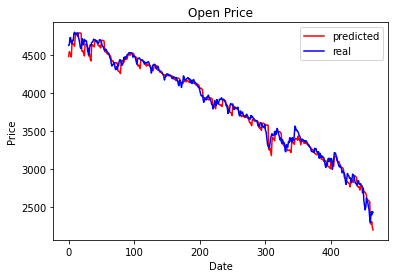

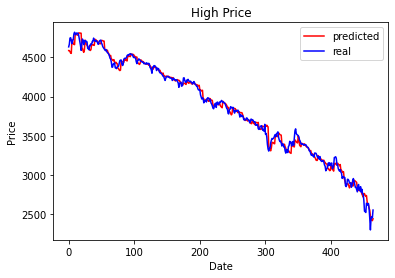

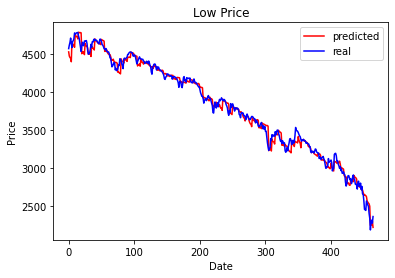

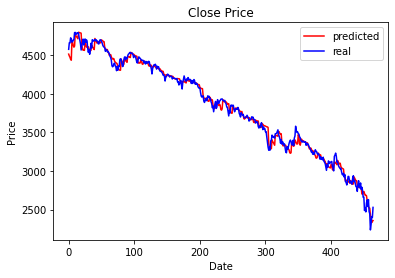

In [66]:
for i in range(columns):
    length = len(pred_data[i])
    plt.plot(range(length), pred_data[i], color ='r', 
             label ='predicted')

    plt.plot(range(length), real_data[i], color ='b', 
             label ='real')

    # naming of x-axis and y-axis
    plt.xlabel('Date')
    plt.ylabel('Price')

    # naming the title of the plot
    plt.title(titles[i])

    plt.legend()
    plt.show()